# Advanced Transformer Models Training on AutismDataset

This notebook trains state-of-the-art transformer models (DeiT, Swin Transformer, ConvNeXt, MViT v2, and CLIP Vision Encoder) on the AutismDataset for autism spectrum disorder detection.

## Models to be trained:
1. **DeiT (Data-efficient Image Transformer)** - Tiny, Small, Base variants
2. **Swin Transformer** - Tiny, Small, Base variants  
3. **ConvNeXt** - Tiny, Small, Base variants
4. **MViT v2 (Multiscale Vision Transformer)** - Tiny, Small, Base variants
5. **CLIP Vision Encoder** - ViT-B/32 adapted for binary classification

Each model will be trained with proper data augmentation, early stopping, and comprehensive evaluation metrics.

# Data Preprocessing and Setup

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.optim as optim
import torchvision.models as models
import time
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch.nn.functional as F
import timm  # For advanced transformer models
import glob
from sklearn.model_selection import train_test_split

## Data Transformations

In [2]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

## Dataset Loading and Preprocessing

We'll create the dataset structure from the AutismDataset folder which contains individual image files organized by class.

In [3]:
def create_dataset_from_folders():
    """
    Create dataset from AutismDataset folder structure
    Returns train, validation, and test splits
    
    Dataset structure:
    - train/: Mixed files (Autistic.X.jpg and Non_Autistic.X.jpg)
    - test/: Mixed files (Autistic.X.jpg and Non_Autistic.X.jpg) 
    - valid/: Subdirectories (Autistic/ and Non_Autistic/)
    """
    base_path = '/kaggle/input/autism-image-data/AutismDataset'
    
    # Train and Test folders have mixed structure (files named by class)
    autistic_train = glob.glob(os.path.join(base_path, 'train', 'Autistic.*.jpg'))
    non_autistic_train = glob.glob(os.path.join(base_path, 'train', 'Non_Autistic.*.jpg'))
    
    autistic_test = glob.glob(os.path.join(base_path, 'test', 'Autistic.*.jpg'))
    non_autistic_test = glob.glob(os.path.join(base_path, 'test', 'Non_Autistic.*.jpg'))
    
    # Valid folder has subdirectory structure
    autistic_valid = glob.glob(os.path.join(base_path, 'valid', 'Autistic', '*.jpg'))
    non_autistic_valid = glob.glob(os.path.join(base_path, 'valid', 'Non_Autistic', '*.jpg'))
    
    # Create dataframes
    train_data = []
    train_data.extend([(path, 'Autistic') for path in autistic_train])
    train_data.extend([(path, 'Non_Autistic') for path in non_autistic_train])
    
    test_data = []
    test_data.extend([(path, 'Autistic') for path in autistic_test])
    test_data.extend([(path, 'Non_Autistic') for path in non_autistic_test])
    
    valid_data = []
    valid_data.extend([(path, 'Autistic') for path in autistic_valid])
    valid_data.extend([(path, 'Non_Autistic') for path in non_autistic_valid])
    
    # Convert to DataFrames
    train_df = pd.DataFrame(train_data, columns=['image_path', 'labels'])
    test_df = pd.DataFrame(test_data, columns=['image_path', 'labels'])
    valid_df = pd.DataFrame(valid_data, columns=['image_path', 'labels'])
    
    # Display dataset statistics
    print(f"Training samples: {len(train_df)}")
    print(f"  - Autistic: {len([x for x in train_data if x[1] == 'Autistic'])}")
    print(f"  - Non_Autistic: {len([x for x in train_data if x[1] == 'Non_Autistic'])}")
    
    print(f"Validation samples: {len(valid_df)}")
    print(f"  - Autistic: {len([x for x in valid_data if x[1] == 'Autistic'])}")
    print(f"  - Non_Autistic: {len([x for x in valid_data if x[1] == 'Non_Autistic'])}")
    
    print(f"Test samples: {len(test_df)}")
    print(f"  - Autistic: {len([x for x in test_data if x[1] == 'Autistic'])}")
    print(f"  - Non_Autistic: {len([x for x in test_data if x[1] == 'Non_Autistic'])}")
    
    print(f"Classes: {train_df['labels'].unique()}")
    
    return train_df, valid_df, test_df

# Create the dataset
train_df, valid_df, test_df = create_dataset_from_folders()

Training samples: 2540
  - Autistic: 1270
  - Non_Autistic: 1270
Validation samples: 100
  - Autistic: 50
  - Non_Autistic: 50
Test samples: 300
  - Autistic: 150
  - Non_Autistic: 150
Classes: ['Autistic' 'Non_Autistic']


## Custom Dataset Class for AutismDataset

In [4]:
BATCH_SIZE = 16
NUM_WORKERS = 4

class AutismDataset(Dataset):
    def __init__(self, dataframe, transform=None, label_encoder=None, fit_label_encoder=False):
        """
        Args:
            dataframe (pd.DataFrame): DataFrame with 'image_path' and 'labels' columns
            transform (callable, optional): Optional transform to be applied on a sample.
            label_encoder (LabelEncoder, optional): Pre-fitted label encoder. If None, creates new one.
            fit_label_encoder (bool): Whether to fit the label encoder on this dataset's labels.
        """
        self.data = dataframe
        self.transform = transform
        
        if label_encoder is None:
            self.label_encoder = LabelEncoder()
            if fit_label_encoder:
                self.labels = self.label_encoder.fit_transform(self.data['labels'])
            else:
                raise ValueError("Must provide label_encoder or set fit_label_encoder=True")
        else:
            self.label_encoder = label_encoder
            self.labels = self.label_encoder.transform(self.data['labels'])
        
        self.image_paths = self.data['image_path'].tolist()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Load image
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            # Create a black placeholder image if file is missing/corrupted
            image = Image.new('RGB', (224, 224), color='black')
        
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long)
    
    def get_label_encoder(self):
        """Return the label encoder for use with other datasets"""
        return self.label_encoder
    
    def get_class_names(self):
        """Return the original class names"""
        return self.label_encoder.classes_

In [5]:
# Create datasets
def create_datasets(train_df, val_df, test_df):
    """
    Create train, validation, and test datasets with proper label encoding
    """
    # Create training dataset first to fit label encoder
    train_dataset = AutismDataset(
        dataframe=train_df, 
        transform=train_transform,
        fit_label_encoder=True  
    )
    
    # Get label encoder from training set
    le = train_dataset.get_label_encoder()
    
    # Create validation and test datasets using the same label encoder
    val_dataset = AutismDataset(
        dataframe=val_df,
        transform=val_test_transform,
        label_encoder=le
    )
    
    test_dataset = AutismDataset(
        dataframe=test_df,
        transform=val_test_transform,
        label_encoder=le
    )
    
    return train_dataset, val_dataset, test_dataset, le

In [6]:
# Create dataloaders
def create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    """
    Create dataloaders for training, validation, and testing
    """
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    return train_loader, val_loader, test_loader

In [7]:
# Create datasets and dataloaders
train_dataset, val_dataset, test_dataset, label_encoder = create_datasets(train_df, valid_df, test_df)

# Create dataloaders
train_loader, val_loader, test_loader = create_dataloaders(
    train_dataset, val_dataset, test_dataset, 
    batch_size=32, 
    num_workers=4
)

print(f"\nDataset Summary:")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Classes: {label_encoder.classes_}")
print(f"Number of classes: {len(label_encoder.classes_)}")

# Verify class distribution
print(f"\nClass Distribution:")
print("Training:")
print(train_df['labels'].value_counts())
print("Validation:")
print(valid_df['labels'].value_counts())
print("Test:")
print(test_df['labels'].value_counts())


Dataset Summary:
Training samples: 2540
Validation samples: 100
Test samples: 300
Classes: ['Autistic' 'Non_Autistic']
Number of classes: 2

Class Distribution:
Training:
labels
Autistic        1270
Non_Autistic    1270
Name: count, dtype: int64
Validation:
labels
Autistic        50
Non_Autistic    50
Name: count, dtype: int64
Test:
labels
Autistic        150
Non_Autistic    150
Name: count, dtype: int64


# Model Training Framework

In [8]:
class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, test_loader, device='cuda'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        
        # Training history
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        
    def train_model(self, num_epochs=25, lr=0.001, weight_decay=1e-4, save_best=True, model_name="model"):
        """Train the model with early stopping and best model saving"""
        
        # Loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        
        # Best model tracking
        best_val_acc = 0.0
        best_model_wts = copy.deepcopy(self.model.state_dict())
        patience = 5
        patience_counter = 0
        
        print(f"Starting training for {num_epochs} epochs...")
        print("-" * 60)
        
        start_time = time.time()
        
        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)
            
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    self.model.train()
                    dataloader = self.train_loader
                else:
                    self.model.eval()
                    dataloader = self.val_loader
                
                running_loss = 0.0
                running_corrects = 0
                total_samples = 0
                
                # Progress bar
                pbar = tqdm(dataloader, desc=f'{phase.capitalize()} ')
                
                for inputs, labels in pbar:
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)
                    
                    # Zero gradients
                    optimizer.zero_grad()
                    
                    # Forward pass
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        # Backward pass (only in training)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    total_samples += inputs.size(0)
                    
                    # Update progress bar
                    current_acc = running_corrects.double() / total_samples
                    pbar.set_postfix({
                        'Loss': f'{running_loss/total_samples:.4f}',
                        'Acc': f'{current_acc:.4f}'
                    })
                
                # Calculate epoch metrics
                epoch_loss = running_loss / total_samples
                epoch_acc = running_corrects.double() / total_samples
                
                print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                
                # Store metrics
                if phase == 'train':
                    self.train_losses.append(epoch_loss)
                    self.train_accuracies.append(epoch_acc.cpu())
                else:
                    self.val_losses.append(epoch_loss)
                    self.val_accuracies.append(epoch_acc.cpu())
                
                # Save best model
                if phase == 'val' and epoch_acc > best_val_acc:
                    best_val_acc = epoch_acc
                    best_model_wts = copy.deepcopy(self.model.state_dict())
                    patience_counter = 0
                    if save_best:
                        torch.save(self.model.state_dict(), f'best_{model_name}.pth')
                        print(f'✓ New best model saved with validation accuracy: {best_val_acc:.4f}')
                elif phase == 'val':
                    patience_counter += 1
            
            # Learning rate scheduler step
            if phase == 'train':
                scheduler.step()
            
            # Early stopping
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break
                
            print()
        
        # Training complete
        time_elapsed = time.time() - start_time
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best validation accuracy: {best_val_acc:.4f}')
        
        # Load best model weights
        self.model.load_state_dict(best_model_wts)
        return self.model
    
    def evaluate_model(self, test_loader=None):
        """Evaluate model on test set"""
        if test_loader is None:
            test_loader = self.test_loader
            
        self.model.eval()
        all_preds = []
        all_labels = []
        test_loss = 0.0
        correct = 0
        total = 0
        
        criterion = nn.CrossEntropyLoss()
        
        print("Evaluating on test set...")
        with torch.no_grad():
            for inputs, labels in tqdm(test_loader):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                test_loss += loss.item()
                
                # Store for detailed metrics
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        # Calculate metrics
        test_acc = 100 * correct / total
        avg_test_loss = test_loss / len(test_loader)
        
        print(f'Test Accuracy: {test_acc:.2f}%')
        print(f'Test Loss: {avg_test_loss:.4f}')
        
        # Detailed classification report
        print("\nClassification Report:")
        # Note: LabelEncoder sorts alphabetically, so 'Autistic' (0) and 'Non_Autistic' (1)
        print(classification_report(all_labels, all_preds, target_names=['Autistic', 'Non_Autistic']))
        
        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        print(f"\nConfusion Matrix:")
        print(cm)
        
        return test_acc, all_preds, all_labels
    
    def plot_training_history(self, save_path=None):
        """Plot training and validation metrics"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot losses
        ax1.plot(self.train_losses, label='Train Loss', marker='o')
        ax1.plot(self.val_losses, label='Validation Loss', marker='s')
        ax1.set_title('Model Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Plot accuracies
        ax2.plot(self.train_accuracies, label='Train Accuracy', marker='o')
        ax2.plot(self.val_accuracies, label='Validation Accuracy', marker='s')
        ax2.set_title('Model Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path)
        plt.show()

# Advanced Transformer Model Architectures

## 1. DeiT (Data-efficient Image Transformer) Models

In [9]:
def create_deit_model(architecture='deit_base_patch16_224', num_classes=2, pretrained=True):
    """Create DeiT (Data-efficient Image Transformer) model for binary classification"""
    if architecture == 'deit_tiny_patch16_224':
        model = timm.create_model('deit_tiny_patch16_224', pretrained=pretrained, num_classes=num_classes)
    elif architecture == 'deit_small_patch16_224':
        model = timm.create_model('deit_small_patch16_224', pretrained=pretrained, num_classes=num_classes)
    elif architecture == 'deit_base_patch16_224':
        model = timm.create_model('deit_base_patch16_224', pretrained=pretrained, num_classes=num_classes)
    else:
        raise ValueError("Architecture must be 'deit_tiny_patch16_224', 'deit_small_patch16_224', or 'deit_base_patch16_224'")
    
    return model

## 2. Swin Transformer Models

In [10]:
def create_swin_model(architecture='swin_tiny_patch4_window7_224', num_classes=2, pretrained=True):
    """Create Swin Transformer model for binary classification"""
    if architecture == 'swin_tiny_patch4_window7_224':
        model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=pretrained, num_classes=num_classes)
    elif architecture == 'swin_small_patch4_window7_224':
        model = timm.create_model('swin_small_patch4_window7_224', pretrained=pretrained, num_classes=num_classes)
    elif architecture == 'swin_base_patch4_window7_224':
        model = timm.create_model('swin_base_patch4_window7_224', pretrained=pretrained, num_classes=num_classes)
    else:
        raise ValueError("Architecture must be 'swin_tiny_patch4_window7_224', 'swin_small_patch4_window7_224', or 'swin_base_patch4_window7_224'")
    
    return model

## 3. ConvNeXt Models

In [11]:
def create_convnext_model(architecture='convnext_tiny', num_classes=2, pretrained=True):
    """Create ConvNeXt model for binary classification"""
    if architecture == 'convnext_tiny':
        model = timm.create_model('convnext_tiny', pretrained=pretrained, num_classes=num_classes)
    elif architecture == 'convnext_small':
        model = timm.create_model('convnext_small', pretrained=pretrained, num_classes=num_classes)
    elif architecture == 'convnext_base':
        model = timm.create_model('convnext_base', pretrained=pretrained, num_classes=num_classes)
    else:
        raise ValueError("Architecture must be 'convnext_tiny', 'convnext_small', or 'convnext_base'")
    
    return model

## 4. MViT v2 (Multiscale Vision Transformer) Models

In [12]:
def create_mvit_model(architecture='mvitv2_tiny', num_classes=2, pretrained=True):
    """Create MViT v2 (Multiscale Vision Transformer) model for binary classification"""
    if architecture == 'mvitv2_tiny':
        model = timm.create_model('mvitv2_tiny', pretrained=pretrained, num_classes=num_classes)
    elif architecture == 'mvitv2_small':
        model = timm.create_model('mvitv2_small', pretrained=pretrained, num_classes=num_classes)
    elif architecture == 'mvitv2_base':
        model = timm.create_model('mvitv2_base', pretrained=pretrained, num_classes=num_classes)
    else:
        raise ValueError("Architecture must be 'mvitv2_tiny', 'mvitv2_small', or 'mvitv2_base'")
    
    return model

## 5. CLIP Vision Encoder Model

In [13]:
class CLIPVisionEncoder(nn.Module):
    """CLIP Vision Encoder adapted for binary classification"""
    def __init__(self, num_classes=2):
        super(CLIPVisionEncoder, self).__init__()
        
        # Load CLIP ViT-B/32 vision encoder
        self.vision_encoder = timm.create_model('vit_base_patch32_clip_224', pretrained=True, num_classes=0)  # Remove classifier
        
        # Get the feature dimension
        feature_dim = self.vision_encoder.num_features
        
        # Add custom classifier for binary classification
        self.classifier = nn.Sequential(
            nn.LayerNorm(feature_dim),
            nn.Dropout(0.1),
            nn.Linear(feature_dim, num_classes)
        )
        
    def forward(self, x):
        # Extract features using CLIP vision encoder
        features = self.vision_encoder(x)
        
        # Classify
        logits = self.classifier(features)
        
        return logits

def create_clip_model(num_classes=2):
    """Create CLIP ViT-B/32 vision encoder for binary classification"""
    return CLIPVisionEncoder(num_classes=num_classes)

# GPU Configuration

In [14]:
# Test data loading
print("Testing data loading...")
try:
    # Test loading a batch from each loader
    train_batch = next(iter(train_loader))
    val_batch = next(iter(val_loader))
    test_batch = next(iter(test_loader))
    
    print(f"✓ Train batch shape: {train_batch[0].shape}, Labels: {train_batch[1].shape}")
    print(f"✓ Val batch shape: {val_batch[0].shape}, Labels: {val_batch[1].shape}")
    print(f"✓ Test batch shape: {test_batch[0].shape}, Labels: {test_batch[1].shape}")
    print("✓ Data loading successful!\n")
except Exception as e:
    print(f"✗ Data loading failed: {e}")
    raise e

Testing data loading...
✓ Train batch shape: torch.Size([32, 3, 224, 224]), Labels: torch.Size([32])
✓ Val batch shape: torch.Size([32, 3, 224, 224]), Labels: torch.Size([32])
✓ Test batch shape: torch.Size([32, 3, 224, 224]), Labels: torch.Size([32])
✓ Data loading successful!



In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

Using device: cuda
GPU: Tesla P100-PCIE-16GB
Memory: 15.89 GB


# Model Training Sections

## 1. DeiT (Data-efficient Image Transformer) Training

### DeiT Tiny

Creating DeiT Tiny model...


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

Training DeiT Tiny model...
Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 79/79 [00:10<00:00,  7.86it/s, Loss=0.7186, Acc=0.5700]


Train Loss: 0.7186 Acc: 0.5700


Val : 100%|██████████| 4/4 [00:00<00:00,  8.85it/s, Loss=0.6272, Acc=0.6500]


Val Loss: 0.6272 Acc: 0.6500
✓ New best model saved with validation accuracy: 0.6500

Epoch 2/25
----------


Train : 100%|██████████| 79/79 [00:06<00:00, 11.80it/s, Loss=0.6240, Acc=0.6452]


Train Loss: 0.6240 Acc: 0.6452


Val : 100%|██████████| 4/4 [00:00<00:00,  8.90it/s, Loss=0.6185, Acc=0.6700]


Val Loss: 0.6185 Acc: 0.6700
✓ New best model saved with validation accuracy: 0.6700

Epoch 3/25
----------


Train : 100%|██████████| 79/79 [00:06<00:00, 11.90it/s, Loss=0.5827, Acc=0.6907]


Train Loss: 0.5827 Acc: 0.6907


Val : 100%|██████████| 4/4 [00:00<00:00,  8.52it/s, Loss=0.6134, Acc=0.7000]


Val Loss: 0.6134 Acc: 0.7000
✓ New best model saved with validation accuracy: 0.7000

Epoch 4/25
----------


Train : 100%|██████████| 79/79 [00:06<00:00, 11.50it/s, Loss=0.5572, Acc=0.7160]


Train Loss: 0.5572 Acc: 0.7160


Val : 100%|██████████| 4/4 [00:00<00:00,  8.76it/s, Loss=0.6155, Acc=0.6500]


Val Loss: 0.6155 Acc: 0.6500

Epoch 5/25
----------


Train : 100%|██████████| 79/79 [00:06<00:00, 11.71it/s, Loss=0.5525, Acc=0.7093]


Train Loss: 0.5525 Acc: 0.7093


Val : 100%|██████████| 4/4 [00:00<00:00,  9.34it/s, Loss=0.5348, Acc=0.6600]


Val Loss: 0.5348 Acc: 0.6600

Epoch 6/25
----------


Train : 100%|██████████| 79/79 [00:06<00:00, 11.69it/s, Loss=0.5521, Acc=0.7112]


Train Loss: 0.5521 Acc: 0.7112


Val : 100%|██████████| 4/4 [00:00<00:00,  8.37it/s, Loss=0.5869, Acc=0.7200]


Val Loss: 0.5869 Acc: 0.7200
✓ New best model saved with validation accuracy: 0.7200

Epoch 7/25
----------


Train : 100%|██████████| 79/79 [00:06<00:00, 11.84it/s, Loss=0.5327, Acc=0.7290]


Train Loss: 0.5327 Acc: 0.7290


Val : 100%|██████████| 4/4 [00:00<00:00,  9.12it/s, Loss=0.5691, Acc=0.7200]


Val Loss: 0.5691 Acc: 0.7200

Epoch 8/25
----------


Train : 100%|██████████| 79/79 [00:06<00:00, 11.81it/s, Loss=0.5181, Acc=0.7346]


Train Loss: 0.5181 Acc: 0.7346


Val : 100%|██████████| 4/4 [00:00<00:00,  8.88it/s, Loss=0.5117, Acc=0.7700]


Val Loss: 0.5117 Acc: 0.7700
✓ New best model saved with validation accuracy: 0.7700

Epoch 9/25
----------


Train : 100%|██████████| 79/79 [00:06<00:00, 11.55it/s, Loss=0.5114, Acc=0.7366]


Train Loss: 0.5114 Acc: 0.7366


Val : 100%|██████████| 4/4 [00:00<00:00,  8.80it/s, Loss=0.5775, Acc=0.6900]


Val Loss: 0.5775 Acc: 0.6900

Epoch 10/25
----------


Train : 100%|██████████| 79/79 [00:06<00:00, 11.92it/s, Loss=0.5216, Acc=0.7298]


Train Loss: 0.5216 Acc: 0.7298


Val : 100%|██████████| 4/4 [00:00<00:00,  8.78it/s, Loss=0.6094, Acc=0.6900]


Val Loss: 0.6094 Acc: 0.6900

Epoch 11/25
----------


Train : 100%|██████████| 79/79 [00:06<00:00, 11.75it/s, Loss=0.4893, Acc=0.7551]


Train Loss: 0.4893 Acc: 0.7551


Val : 100%|██████████| 4/4 [00:00<00:00,  8.97it/s, Loss=0.5450, Acc=0.7700]


Val Loss: 0.5450 Acc: 0.7700

Epoch 12/25
----------


Train : 100%|██████████| 79/79 [00:06<00:00, 11.82it/s, Loss=0.4751, Acc=0.7658]


Train Loss: 0.4751 Acc: 0.7658


Val : 100%|██████████| 4/4 [00:00<00:00,  8.75it/s, Loss=0.5871, Acc=0.7200]


Val Loss: 0.5871 Acc: 0.7200

Epoch 13/25
----------


Train : 100%|██████████| 79/79 [00:06<00:00, 11.86it/s, Loss=0.4653, Acc=0.7706]


Train Loss: 0.4653 Acc: 0.7706


Val : 100%|██████████| 4/4 [00:00<00:00,  8.89it/s, Loss=0.5334, Acc=0.7500]


Val Loss: 0.5334 Acc: 0.7500
Early stopping triggered after 13 epochs
Training complete in 1m 37s
Best validation accuracy: 0.7700
Evaluating DeiT Tiny model...
Evaluating on test set...


100%|██████████| 10/10 [00:01<00:00,  9.02it/s]


Test Accuracy: 72.33%
Test Loss: 0.5080

Classification Report:
              precision    recall  f1-score   support

    Autistic       0.73      0.71      0.72       150
Non_Autistic       0.72      0.74      0.73       150

    accuracy                           0.72       300
   macro avg       0.72      0.72      0.72       300
weighted avg       0.72      0.72      0.72       300


Confusion Matrix:
[[106  44]
 [ 39 111]]
Plotting DeiT Tiny training history...


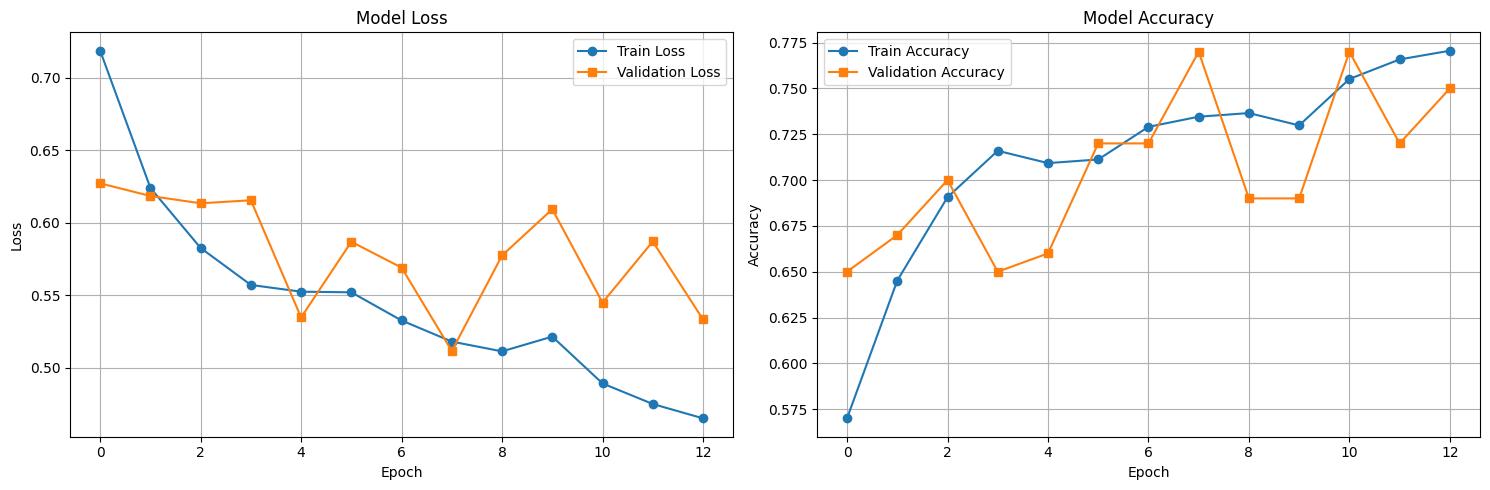

In [16]:
# Create and train DeiT Tiny model
print("Creating DeiT Tiny model...")
deit_tiny_model = create_deit_model('deit_tiny_patch16_224')
deit_tiny_trainer = ModelTrainer(deit_tiny_model, train_loader, val_loader, test_loader, device)

print("Training DeiT Tiny model...")
trained_deit_tiny = deit_tiny_trainer.train_model(num_epochs=25, model_name="deit_tiny_autism")

print("Evaluating DeiT Tiny model...")
test_acc_deit_tiny, preds_deit_tiny, labels_deit_tiny = deit_tiny_trainer.evaluate_model()

print("Plotting DeiT Tiny training history...")
deit_tiny_trainer.plot_training_history()

### DeiT Small

Creating DeiT Small model...


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

Training DeiT Small model...
Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 79/79 [00:15<00:00,  5.17it/s, Loss=0.7631, Acc=0.5301]


Train Loss: 0.7631 Acc: 0.5301


Val : 100%|██████████| 4/4 [00:00<00:00,  6.98it/s, Loss=0.6767, Acc=0.5500]


Val Loss: 0.6767 Acc: 0.5500
✓ New best model saved with validation accuracy: 0.5500

Epoch 2/25
----------


Train : 100%|██████████| 79/79 [00:15<00:00,  5.18it/s, Loss=0.6570, Acc=0.6092]


Train Loss: 0.6570 Acc: 0.6092


Val : 100%|██████████| 4/4 [00:00<00:00,  6.92it/s, Loss=0.6244, Acc=0.5900]


Val Loss: 0.6244 Acc: 0.5900
✓ New best model saved with validation accuracy: 0.5900

Epoch 3/25
----------


Train : 100%|██████████| 79/79 [00:15<00:00,  5.19it/s, Loss=0.6544, Acc=0.6108]


Train Loss: 0.6544 Acc: 0.6108


Val : 100%|██████████| 4/4 [00:00<00:00,  6.95it/s, Loss=0.6368, Acc=0.6500]


Val Loss: 0.6368 Acc: 0.6500
✓ New best model saved with validation accuracy: 0.6500

Epoch 4/25
----------


Train : 100%|██████████| 79/79 [00:15<00:00,  5.21it/s, Loss=0.6242, Acc=0.6456]


Train Loss: 0.6242 Acc: 0.6456


Val : 100%|██████████| 4/4 [00:00<00:00,  7.43it/s, Loss=0.6281, Acc=0.6100]


Val Loss: 0.6281 Acc: 0.6100

Epoch 5/25
----------


Train : 100%|██████████| 79/79 [00:15<00:00,  5.20it/s, Loss=0.6309, Acc=0.6377]


Train Loss: 0.6309 Acc: 0.6377


Val : 100%|██████████| 4/4 [00:00<00:00,  7.08it/s, Loss=0.6098, Acc=0.6700]


Val Loss: 0.6098 Acc: 0.6700
✓ New best model saved with validation accuracy: 0.6700

Epoch 6/25
----------


Train : 100%|██████████| 79/79 [00:15<00:00,  5.17it/s, Loss=0.5917, Acc=0.6729]


Train Loss: 0.5917 Acc: 0.6729


Val : 100%|██████████| 4/4 [00:00<00:00,  7.51it/s, Loss=0.6724, Acc=0.5900]


Val Loss: 0.6724 Acc: 0.5900

Epoch 7/25
----------


Train : 100%|██████████| 79/79 [00:15<00:00,  5.16it/s, Loss=0.5954, Acc=0.6768]


Train Loss: 0.5954 Acc: 0.6768


Val : 100%|██████████| 4/4 [00:00<00:00,  7.07it/s, Loss=0.6521, Acc=0.5700]


Val Loss: 0.6521 Acc: 0.5700

Epoch 8/25
----------


Train : 100%|██████████| 79/79 [00:15<00:00,  5.18it/s, Loss=0.6007, Acc=0.6733]


Train Loss: 0.6007 Acc: 0.6733


Val : 100%|██████████| 4/4 [00:00<00:00,  6.99it/s, Loss=0.6553, Acc=0.5900]


Val Loss: 0.6553 Acc: 0.5900

Epoch 9/25
----------


Train : 100%|██████████| 79/79 [00:15<00:00,  5.21it/s, Loss=0.5909, Acc=0.6867]


Train Loss: 0.5909 Acc: 0.6867


Val : 100%|██████████| 4/4 [00:00<00:00,  7.16it/s, Loss=0.6130, Acc=0.6200]


Val Loss: 0.6130 Acc: 0.6200

Epoch 10/25
----------


Train : 100%|██████████| 79/79 [00:15<00:00,  5.21it/s, Loss=0.5639, Acc=0.7097]


Train Loss: 0.5639 Acc: 0.7097


Val : 100%|██████████| 4/4 [00:00<00:00,  6.87it/s, Loss=0.5475, Acc=0.7400]


Val Loss: 0.5475 Acc: 0.7400
✓ New best model saved with validation accuracy: 0.7400

Epoch 11/25
----------


Train : 100%|██████████| 79/79 [00:15<00:00,  5.17it/s, Loss=0.5550, Acc=0.7144]


Train Loss: 0.5550 Acc: 0.7144


Val : 100%|██████████| 4/4 [00:00<00:00,  7.57it/s, Loss=0.6002, Acc=0.6700]


Val Loss: 0.6002 Acc: 0.6700

Epoch 12/25
----------


Train : 100%|██████████| 79/79 [00:15<00:00,  5.18it/s, Loss=0.5772, Acc=0.6986]


Train Loss: 0.5772 Acc: 0.6986


Val : 100%|██████████| 4/4 [00:00<00:00,  7.21it/s, Loss=0.5748, Acc=0.7200]


Val Loss: 0.5748 Acc: 0.7200

Epoch 13/25
----------


Train : 100%|██████████| 79/79 [00:15<00:00,  5.19it/s, Loss=0.5464, Acc=0.7148]


Train Loss: 0.5464 Acc: 0.7148


Val : 100%|██████████| 4/4 [00:00<00:00,  6.80it/s, Loss=0.5558, Acc=0.7300]


Val Loss: 0.5558 Acc: 0.7300

Epoch 14/25
----------


Train : 100%|██████████| 79/79 [00:15<00:00,  5.21it/s, Loss=0.5325, Acc=0.7342]


Train Loss: 0.5325 Acc: 0.7342


Val : 100%|██████████| 4/4 [00:00<00:00,  7.00it/s, Loss=0.6173, Acc=0.6800]


Val Loss: 0.6173 Acc: 0.6800

Epoch 15/25
----------


Train : 100%|██████████| 79/79 [00:15<00:00,  5.20it/s, Loss=0.5354, Acc=0.7271]


Train Loss: 0.5354 Acc: 0.7271


Val : 100%|██████████| 4/4 [00:00<00:00,  6.81it/s, Loss=0.5730, Acc=0.6400]


Val Loss: 0.5730 Acc: 0.6400
Early stopping triggered after 15 epochs
Training complete in 3m 58s
Best validation accuracy: 0.7400
Evaluating DeiT Small model...
Evaluating on test set...


100%|██████████| 10/10 [00:00<00:00, 10.04it/s]


Test Accuracy: 72.00%
Test Loss: 0.5355

Classification Report:
              precision    recall  f1-score   support

    Autistic       0.71      0.75      0.73       150
Non_Autistic       0.74      0.69      0.71       150

    accuracy                           0.72       300
   macro avg       0.72      0.72      0.72       300
weighted avg       0.72      0.72      0.72       300


Confusion Matrix:
[[113  37]
 [ 47 103]]
Plotting DeiT Small training history...


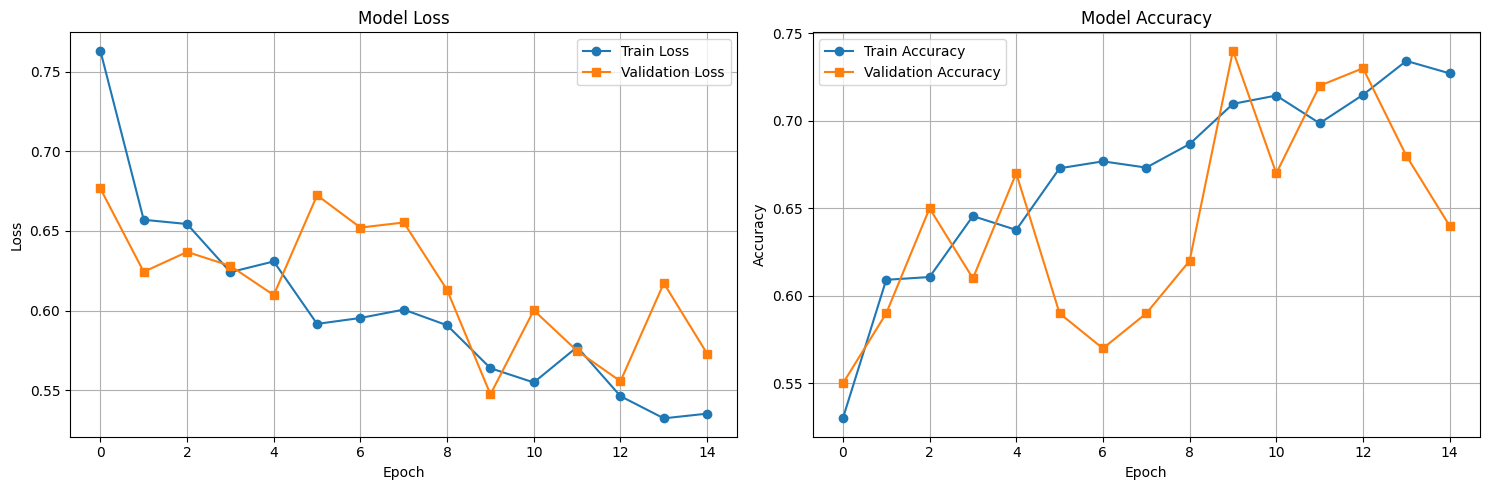

In [17]:
# Create and train DeiT Small model
print("Creating DeiT Small model...")
deit_small_model = create_deit_model('deit_small_patch16_224')
deit_small_trainer = ModelTrainer(deit_small_model, train_loader, val_loader, test_loader, device)

print("Training DeiT Small model...")
trained_deit_small = deit_small_trainer.train_model(num_epochs=25, model_name="deit_small_autism")

print("Evaluating DeiT Small model...")
test_acc_deit_small, preds_deit_small, labels_deit_small = deit_small_trainer.evaluate_model()

print("Plotting DeiT Small training history...")
deit_small_trainer.plot_training_history()

### DeiT Base

Creating DeiT Base model...


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Training DeiT Base model...
Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 79/79 [00:47<00:00,  1.66it/s, Loss=0.7747, Acc=0.5174]


Train Loss: 0.7747 Acc: 0.5174


Val : 100%|██████████| 4/4 [00:01<00:00,  3.92it/s, Loss=0.6823, Acc=0.5600]


Val Loss: 0.6823 Acc: 0.5600
✓ New best model saved with validation accuracy: 0.5600

Epoch 2/25
----------


Train : 100%|██████████| 79/79 [00:47<00:00,  1.66it/s, Loss=0.6692, Acc=0.5866]


Train Loss: 0.6692 Acc: 0.5866


Val : 100%|██████████| 4/4 [00:00<00:00,  4.18it/s, Loss=0.6389, Acc=0.6400]


Val Loss: 0.6389 Acc: 0.6400
✓ New best model saved with validation accuracy: 0.6400

Epoch 3/25
----------


Train : 100%|██████████| 79/79 [00:47<00:00,  1.66it/s, Loss=0.6415, Acc=0.6203]


Train Loss: 0.6415 Acc: 0.6203


Val : 100%|██████████| 4/4 [00:00<00:00,  4.02it/s, Loss=0.6548, Acc=0.6000]


Val Loss: 0.6548 Acc: 0.6000

Epoch 4/25
----------


Train : 100%|██████████| 79/79 [00:47<00:00,  1.66it/s, Loss=0.6179, Acc=0.6638]


Train Loss: 0.6179 Acc: 0.6638


Val : 100%|██████████| 4/4 [00:00<00:00,  4.04it/s, Loss=0.6040, Acc=0.6400]


Val Loss: 0.6040 Acc: 0.6400

Epoch 5/25
----------


Train : 100%|██████████| 79/79 [00:47<00:00,  1.66it/s, Loss=0.5954, Acc=0.6768]


Train Loss: 0.5954 Acc: 0.6768


Val : 100%|██████████| 4/4 [00:00<00:00,  4.01it/s, Loss=0.5534, Acc=0.7000]


Val Loss: 0.5534 Acc: 0.7000
✓ New best model saved with validation accuracy: 0.7000

Epoch 6/25
----------


Train : 100%|██████████| 79/79 [00:47<00:00,  1.66it/s, Loss=0.5927, Acc=0.6863]


Train Loss: 0.5927 Acc: 0.6863


Val : 100%|██████████| 4/4 [00:01<00:00,  3.98it/s, Loss=0.5600, Acc=0.7200]


Val Loss: 0.5600 Acc: 0.7200
✓ New best model saved with validation accuracy: 0.7200

Epoch 7/25
----------


Train : 100%|██████████| 79/79 [00:47<00:00,  1.66it/s, Loss=0.6004, Acc=0.6713]


Train Loss: 0.6004 Acc: 0.6713


Val : 100%|██████████| 4/4 [00:01<00:00,  3.94it/s, Loss=0.5904, Acc=0.6900]


Val Loss: 0.5904 Acc: 0.6900

Epoch 8/25
----------


Train : 100%|██████████| 79/79 [00:47<00:00,  1.66it/s, Loss=0.5807, Acc=0.6843]


Train Loss: 0.5807 Acc: 0.6843


Val : 100%|██████████| 4/4 [00:01<00:00,  3.94it/s, Loss=0.5833, Acc=0.6600]


Val Loss: 0.5833 Acc: 0.6600

Epoch 9/25
----------


Train : 100%|██████████| 79/79 [00:47<00:00,  1.66it/s, Loss=0.5711, Acc=0.6950]


Train Loss: 0.5711 Acc: 0.6950


Val : 100%|██████████| 4/4 [00:01<00:00,  3.96it/s, Loss=0.5827, Acc=0.7000]


Val Loss: 0.5827 Acc: 0.7000

Epoch 10/25
----------


Train : 100%|██████████| 79/79 [00:47<00:00,  1.66it/s, Loss=0.5711, Acc=0.7029]


Train Loss: 0.5711 Acc: 0.7029


Val : 100%|██████████| 4/4 [00:00<00:00,  4.02it/s, Loss=0.5915, Acc=0.7000]


Val Loss: 0.5915 Acc: 0.7000

Epoch 11/25
----------


Train : 100%|██████████| 79/79 [00:47<00:00,  1.66it/s, Loss=0.5561, Acc=0.7116]


Train Loss: 0.5561 Acc: 0.7116


Val : 100%|██████████| 4/4 [00:00<00:00,  4.03it/s, Loss=0.5762, Acc=0.6800]


Val Loss: 0.5762 Acc: 0.6800
Early stopping triggered after 11 epochs
Training complete in 8m 58s
Best validation accuracy: 0.7200
Evaluating DeiT Base model...
Evaluating on test set...


100%|██████████| 10/10 [00:02<00:00,  4.52it/s]


Test Accuracy: 73.00%
Test Loss: 0.5406

Classification Report:
              precision    recall  f1-score   support

    Autistic       0.73      0.72      0.73       150
Non_Autistic       0.73      0.74      0.73       150

    accuracy                           0.73       300
   macro avg       0.73      0.73      0.73       300
weighted avg       0.73      0.73      0.73       300


Confusion Matrix:
[[108  42]
 [ 39 111]]
Plotting DeiT Base training history...


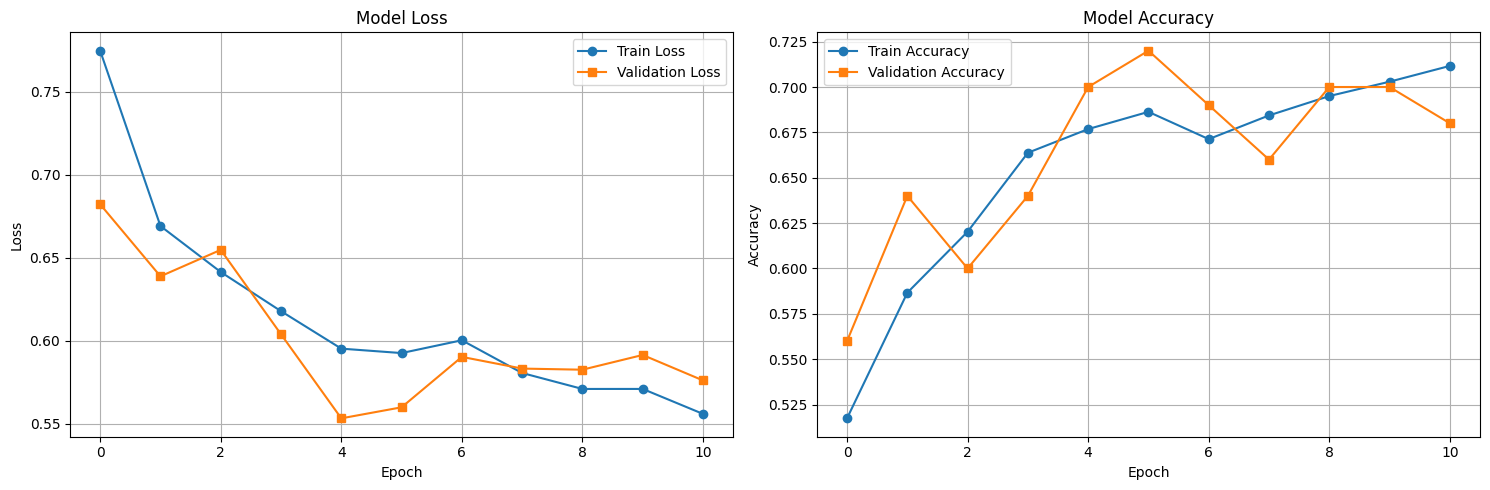

In [18]:
# Create and train DeiT Base model
print("Creating DeiT Base model...")
deit_base_model = create_deit_model('deit_base_patch16_224')
deit_base_trainer = ModelTrainer(deit_base_model, train_loader, val_loader, test_loader, device)

print("Training DeiT Base model...")
trained_deit_base = deit_base_trainer.train_model(num_epochs=25, model_name="deit_base_autism")

print("Evaluating DeiT Base model...")
test_acc_deit_base, preds_deit_base, labels_deit_base = deit_base_trainer.evaluate_model()

print("Plotting DeiT Base training history...")
deit_base_trainer.plot_training_history()

## 2. Swin Transformer Training

### Swin Transformer Tiny

Creating Swin Transformer Tiny model...


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Training Swin Transformer Tiny model...
Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 79/79 [00:20<00:00,  3.90it/s, Loss=0.7308, Acc=0.4980]


Train Loss: 0.7308 Acc: 0.4980


Val : 100%|██████████| 4/4 [00:00<00:00,  5.84it/s, Loss=0.6848, Acc=0.5800]


Val Loss: 0.6848 Acc: 0.5800
✓ New best model saved with validation accuracy: 0.5800

Epoch 2/25
----------


Train : 100%|██████████| 79/79 [00:19<00:00,  3.97it/s, Loss=0.6819, Acc=0.5787]


Train Loss: 0.6819 Acc: 0.5787


Val : 100%|██████████| 4/4 [00:00<00:00,  5.28it/s, Loss=0.6449, Acc=0.6100]


Val Loss: 0.6449 Acc: 0.6100
✓ New best model saved with validation accuracy: 0.6100

Epoch 3/25
----------


Train : 100%|██████████| 79/79 [00:19<00:00,  3.98it/s, Loss=0.6504, Acc=0.6064]


Train Loss: 0.6504 Acc: 0.6064


Val : 100%|██████████| 4/4 [00:00<00:00,  5.78it/s, Loss=0.6627, Acc=0.5600]


Val Loss: 0.6627 Acc: 0.5600

Epoch 4/25
----------


Train : 100%|██████████| 79/79 [00:19<00:00,  3.96it/s, Loss=0.6546, Acc=0.6076]


Train Loss: 0.6546 Acc: 0.6076


Val : 100%|██████████| 4/4 [00:00<00:00,  5.84it/s, Loss=0.6551, Acc=0.5800]


Val Loss: 0.6551 Acc: 0.5800

Epoch 5/25
----------


Train : 100%|██████████| 79/79 [00:20<00:00,  3.94it/s, Loss=0.6849, Acc=0.5637]


Train Loss: 0.6849 Acc: 0.5637


Val : 100%|██████████| 4/4 [00:00<00:00,  5.90it/s, Loss=0.6885, Acc=0.5400]


Val Loss: 0.6885 Acc: 0.5400

Epoch 6/25
----------


Train : 100%|██████████| 79/79 [00:19<00:00,  3.98it/s, Loss=0.6808, Acc=0.5649]


Train Loss: 0.6808 Acc: 0.5649


Val : 100%|██████████| 4/4 [00:00<00:00,  5.86it/s, Loss=0.6608, Acc=0.5500]


Val Loss: 0.6608 Acc: 0.5500

Epoch 7/25
----------


Train : 100%|██████████| 79/79 [00:19<00:00,  3.97it/s, Loss=0.6457, Acc=0.6234]


Train Loss: 0.6457 Acc: 0.6234


Val : 100%|██████████| 4/4 [00:00<00:00,  5.57it/s, Loss=0.6438, Acc=0.6700]


Val Loss: 0.6438 Acc: 0.6700
✓ New best model saved with validation accuracy: 0.6700

Epoch 8/25
----------


Train : 100%|██████████| 79/79 [00:19<00:00,  3.98it/s, Loss=0.6518, Acc=0.6171]


Train Loss: 0.6518 Acc: 0.6171


Val : 100%|██████████| 4/4 [00:00<00:00,  5.54it/s, Loss=0.6334, Acc=0.6700]


Val Loss: 0.6334 Acc: 0.6700

Epoch 9/25
----------


Train : 100%|██████████| 79/79 [00:19<00:00,  3.96it/s, Loss=0.6487, Acc=0.6191]


Train Loss: 0.6487 Acc: 0.6191


Val : 100%|██████████| 4/4 [00:00<00:00,  5.56it/s, Loss=0.6615, Acc=0.5400]


Val Loss: 0.6615 Acc: 0.5400

Epoch 10/25
----------


Train : 100%|██████████| 79/79 [00:19<00:00,  3.96it/s, Loss=0.6475, Acc=0.6203]


Train Loss: 0.6475 Acc: 0.6203


Val : 100%|██████████| 4/4 [00:00<00:00,  5.60it/s, Loss=0.6499, Acc=0.5400]


Val Loss: 0.6499 Acc: 0.5400

Epoch 11/25
----------


Train : 100%|██████████| 79/79 [00:19<00:00,  3.97it/s, Loss=0.6835, Acc=0.5297]


Train Loss: 0.6835 Acc: 0.5297


Val : 100%|██████████| 4/4 [00:00<00:00,  5.45it/s, Loss=0.6934, Acc=0.5000]


Val Loss: 0.6934 Acc: 0.5000

Epoch 12/25
----------


Train : 100%|██████████| 79/79 [00:19<00:00,  3.97it/s, Loss=0.6934, Acc=0.5016]


Train Loss: 0.6934 Acc: 0.5016


Val : 100%|██████████| 4/4 [00:00<00:00,  5.43it/s, Loss=0.6939, Acc=0.5000]


Val Loss: 0.6939 Acc: 0.5000
Early stopping triggered after 12 epochs
Training complete in 4m 9s
Best validation accuracy: 0.6700
Evaluating Swin Transformer Tiny model...
Evaluating on test set...


100%|██████████| 10/10 [00:01<00:00,  8.18it/s]


Test Accuracy: 63.00%
Test Loss: 0.6469

Classification Report:
              precision    recall  f1-score   support

    Autistic       0.59      0.86      0.70       150
Non_Autistic       0.74      0.40      0.52       150

    accuracy                           0.63       300
   macro avg       0.66      0.63      0.61       300
weighted avg       0.66      0.63      0.61       300


Confusion Matrix:
[[129  21]
 [ 90  60]]
Plotting Swin Transformer Tiny training history...


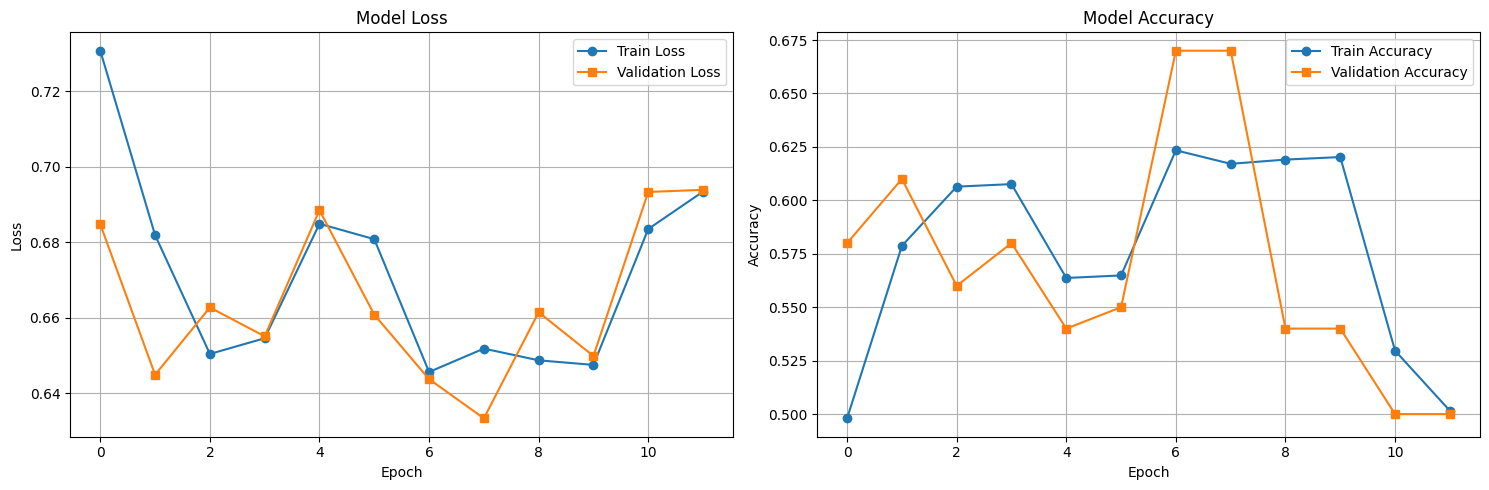

In [19]:
# Create and train Swin Tiny model
print("Creating Swin Transformer Tiny model...")
swin_tiny_model = create_swin_model('swin_tiny_patch4_window7_224')
swin_tiny_trainer = ModelTrainer(swin_tiny_model, train_loader, val_loader, test_loader, device)

print("Training Swin Transformer Tiny model...")
trained_swin_tiny = swin_tiny_trainer.train_model(num_epochs=25, model_name="swin_tiny_autism")

print("Evaluating Swin Transformer Tiny model...")
test_acc_swin_tiny, preds_swin_tiny, labels_swin_tiny = swin_tiny_trainer.evaluate_model()

print("Plotting Swin Transformer Tiny training history...")
swin_tiny_trainer.plot_training_history()

### Swin Transformer Small

Creating Swin Transformer Small model...


model.safetensors:   0%|          | 0.00/200M [00:00<?, ?B/s]

Training Swin Transformer Small model...
Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 79/79 [00:33<00:00,  2.36it/s, Loss=0.7301, Acc=0.4854]


Train Loss: 0.7301 Acc: 0.4854


Val : 100%|██████████| 4/4 [00:00<00:00,  4.53it/s, Loss=0.6974, Acc=0.5000]


Val Loss: 0.6974 Acc: 0.5000
✓ New best model saved with validation accuracy: 0.5000

Epoch 2/25
----------


Train : 100%|██████████| 79/79 [00:33<00:00,  2.36it/s, Loss=0.6991, Acc=0.5012]


Train Loss: 0.6991 Acc: 0.5012


Val : 100%|██████████| 4/4 [00:00<00:00,  4.36it/s, Loss=0.6989, Acc=0.5000]


Val Loss: 0.6989 Acc: 0.5000

Epoch 3/25
----------


Train : 100%|██████████| 79/79 [00:33<00:00,  2.36it/s, Loss=0.6948, Acc=0.5103]


Train Loss: 0.6948 Acc: 0.5103


Val : 100%|██████████| 4/4 [00:00<00:00,  4.43it/s, Loss=0.6602, Acc=0.6100]


Val Loss: 0.6602 Acc: 0.6100
✓ New best model saved with validation accuracy: 0.6100

Epoch 4/25
----------


Train : 100%|██████████| 79/79 [00:33<00:00,  2.36it/s, Loss=0.7107, Acc=0.5099]


Train Loss: 0.7107 Acc: 0.5099


Val : 100%|██████████| 4/4 [00:00<00:00,  4.38it/s, Loss=0.6946, Acc=0.5000]


Val Loss: 0.6946 Acc: 0.5000

Epoch 5/25
----------


Train : 100%|██████████| 79/79 [00:33<00:00,  2.37it/s, Loss=0.6959, Acc=0.5004]


Train Loss: 0.6959 Acc: 0.5004


Val : 100%|██████████| 4/4 [00:00<00:00,  4.63it/s, Loss=0.6951, Acc=0.5000]


Val Loss: 0.6951 Acc: 0.5000

Epoch 6/25
----------


Train : 100%|██████████| 79/79 [00:33<00:00,  2.36it/s, Loss=0.6938, Acc=0.5178]


Train Loss: 0.6938 Acc: 0.5178


Val : 100%|██████████| 4/4 [00:00<00:00,  4.45it/s, Loss=0.6940, Acc=0.5000]


Val Loss: 0.6940 Acc: 0.5000

Epoch 7/25
----------


Train : 100%|██████████| 79/79 [00:33<00:00,  2.36it/s, Loss=0.6957, Acc=0.5020]


Train Loss: 0.6957 Acc: 0.5020


Val : 100%|██████████| 4/4 [00:00<00:00,  4.41it/s, Loss=0.6931, Acc=0.5000]


Val Loss: 0.6931 Acc: 0.5000

Epoch 8/25
----------


Train : 100%|██████████| 79/79 [00:33<00:00,  2.37it/s, Loss=0.6942, Acc=0.4838]


Train Loss: 0.6942 Acc: 0.4838


Val : 100%|██████████| 4/4 [00:00<00:00,  4.42it/s, Loss=0.6932, Acc=0.5000]


Val Loss: 0.6932 Acc: 0.5000
Early stopping triggered after 8 epochs
Training complete in 4m 36s
Best validation accuracy: 0.6100
Evaluating Swin Transformer Small model...
Evaluating on test set...


100%|██████████| 10/10 [00:01<00:00,  5.75it/s]


Test Accuracy: 63.33%
Test Loss: 0.6638

Classification Report:
              precision    recall  f1-score   support

    Autistic       0.59      0.86      0.70       150
Non_Autistic       0.74      0.41      0.53       150

    accuracy                           0.63       300
   macro avg       0.67      0.63      0.61       300
weighted avg       0.67      0.63      0.61       300


Confusion Matrix:
[[129  21]
 [ 89  61]]
Plotting Swin Transformer Small training history...


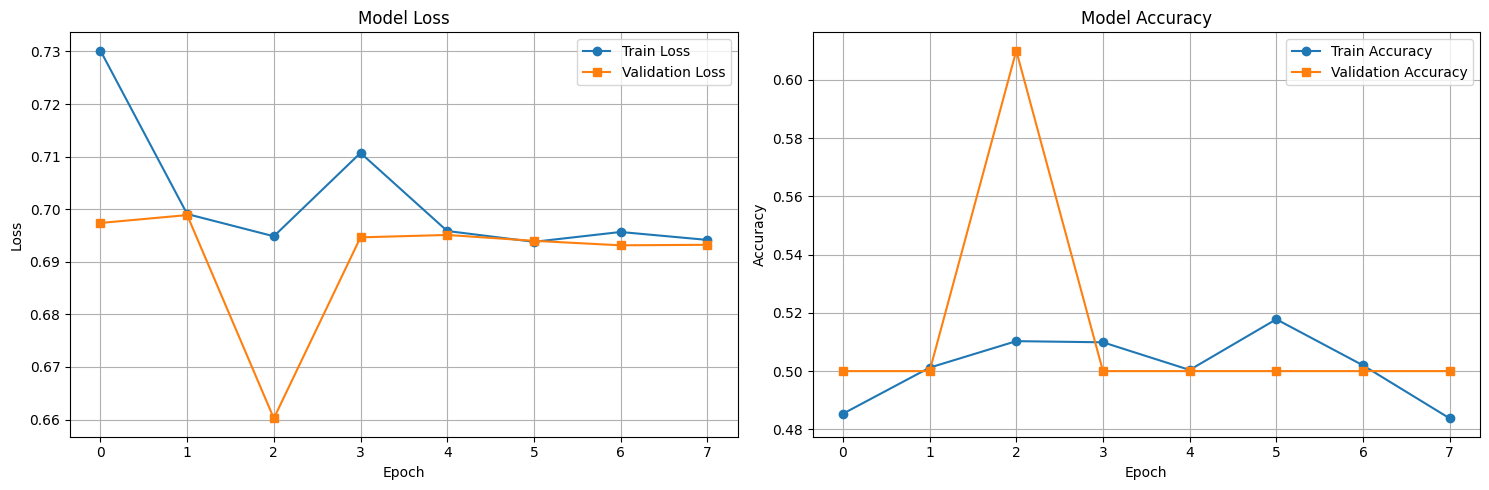

In [20]:
# Create and train Swin Small model
print("Creating Swin Transformer Small model...")
swin_small_model = create_swin_model('swin_small_patch4_window7_224')
swin_small_trainer = ModelTrainer(swin_small_model, train_loader, val_loader, test_loader, device)

print("Training Swin Transformer Small model...")
trained_swin_small = swin_small_trainer.train_model(num_epochs=25, model_name="swin_small_autism")

print("Evaluating Swin Transformer Small model...")
test_acc_swin_small, preds_swin_small, labels_swin_small = swin_small_trainer.evaluate_model()

print("Plotting Swin Transformer Small training history...")
swin_small_trainer.plot_training_history()

### Swin Transformer Base

Creating Swin Transformer Base model...


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

Training Swin Transformer Base model...
Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 79/79 [00:49<00:00,  1.59it/s, Loss=0.7368, Acc=0.5138]


Train Loss: 0.7368 Acc: 0.5138


Val : 100%|██████████| 4/4 [00:01<00:00,  3.59it/s, Loss=0.7268, Acc=0.5000]


Val Loss: 0.7268 Acc: 0.5000
✓ New best model saved with validation accuracy: 0.5000

Epoch 2/25
----------


Train : 100%|██████████| 79/79 [00:49<00:00,  1.59it/s, Loss=0.7050, Acc=0.4976]


Train Loss: 0.7050 Acc: 0.4976


Val : 100%|██████████| 4/4 [00:01<00:00,  3.56it/s, Loss=0.7101, Acc=0.5000]


Val Loss: 0.7101 Acc: 0.5000

Epoch 3/25
----------


Train : 100%|██████████| 79/79 [00:49<00:00,  1.59it/s, Loss=0.7013, Acc=0.4968]


Train Loss: 0.7013 Acc: 0.4968


Val : 100%|██████████| 4/4 [00:01<00:00,  3.53it/s, Loss=0.7143, Acc=0.5000]


Val Loss: 0.7143 Acc: 0.5000

Epoch 4/25
----------


Train : 100%|██████████| 79/79 [00:49<00:00,  1.59it/s, Loss=0.7042, Acc=0.5103]


Train Loss: 0.7042 Acc: 0.5103


Val : 100%|██████████| 4/4 [00:01<00:00,  3.47it/s, Loss=0.6943, Acc=0.5000]


Val Loss: 0.6943 Acc: 0.5000

Epoch 5/25
----------


Train : 100%|██████████| 79/79 [00:49<00:00,  1.59it/s, Loss=0.6961, Acc=0.4937]


Train Loss: 0.6961 Acc: 0.4937


Val : 100%|██████████| 4/4 [00:01<00:00,  3.46it/s, Loss=0.6932, Acc=0.5000]


Val Loss: 0.6932 Acc: 0.5000

Epoch 6/25
----------


Train : 100%|██████████| 79/79 [00:49<00:00,  1.59it/s, Loss=0.6941, Acc=0.4980]


Train Loss: 0.6941 Acc: 0.4980


Val : 100%|██████████| 4/4 [00:01<00:00,  3.50it/s, Loss=0.6930, Acc=0.5000]


Val Loss: 0.6930 Acc: 0.5000
Early stopping triggered after 6 epochs
Training complete in 5m 6s
Best validation accuracy: 0.5000
Evaluating Swin Transformer Base model...
Evaluating on test set...


100%|██████████| 10/10 [00:02<00:00,  4.01it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Accuracy: 50.00%
Test Loss: 0.7433

Classification Report:
              precision    recall  f1-score   support

    Autistic       0.50      1.00      0.67       150
Non_Autistic       0.00      0.00      0.00       150

    accuracy                           0.50       300
   macro avg       0.25      0.50      0.33       300
weighted avg       0.25      0.50      0.33       300


Confusion Matrix:
[[150   0]
 [150   0]]
Plotting Swin Transformer Base training history...


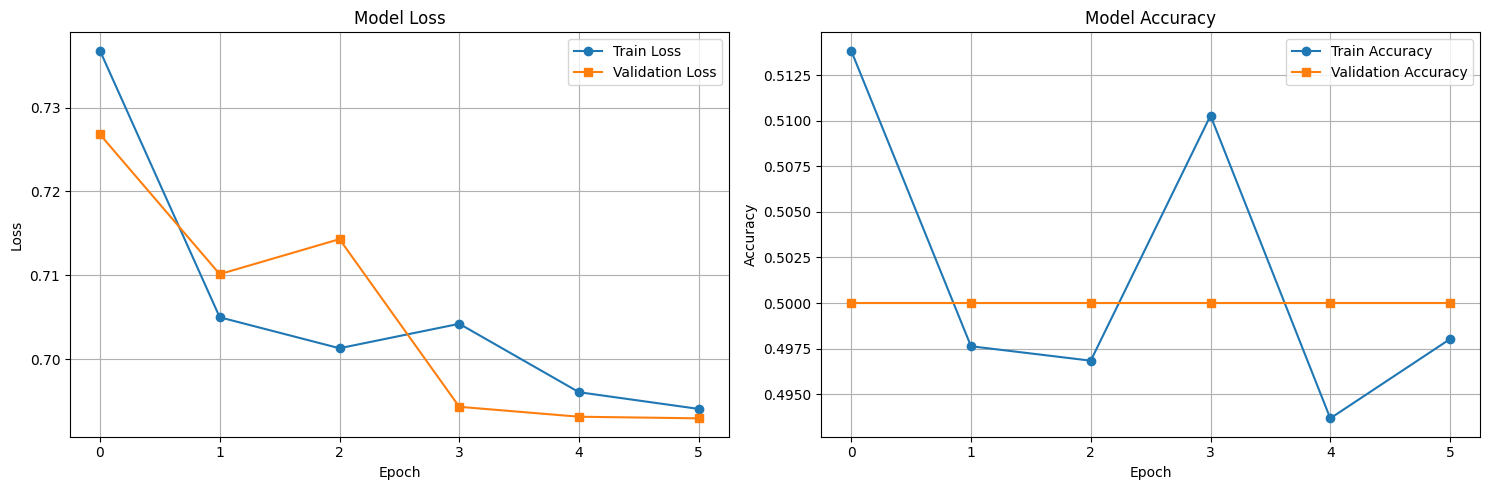

In [21]:
# Create and train Swin Base model
print("Creating Swin Transformer Base model...")
swin_base_model = create_swin_model('swin_base_patch4_window7_224')
swin_base_trainer = ModelTrainer(swin_base_model, train_loader, val_loader, test_loader, device)

print("Training Swin Transformer Base model...")
trained_swin_base = swin_base_trainer.train_model(num_epochs=25, model_name="swin_base_autism")

print("Evaluating Swin Transformer Base model...")
test_acc_swin_base, preds_swin_base, labels_swin_base = swin_base_trainer.evaluate_model()

print("Plotting Swin Transformer Base training history...")
swin_base_trainer.plot_training_history()

## 3. ConvNeXt Training

### ConvNeXt Tiny

Creating ConvNeXt Tiny model...


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Training ConvNeXt Tiny model...
Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 79/79 [00:55<00:00,  1.41it/s, Loss=0.8976, Acc=0.5202]


Train Loss: 0.8976 Acc: 0.5202


Val : 100%|██████████| 4/4 [00:00<00:00,  5.48it/s, Loss=0.7004, Acc=0.5000]


Val Loss: 0.7004 Acc: 0.5000
✓ New best model saved with validation accuracy: 0.5000

Epoch 2/25
----------


Train : 100%|██████████| 79/79 [00:55<00:00,  1.42it/s, Loss=0.7104, Acc=0.4949]


Train Loss: 0.7104 Acc: 0.4949


Val : 100%|██████████| 4/4 [00:00<00:00,  5.65it/s, Loss=0.6973, Acc=0.5000]


Val Loss: 0.6973 Acc: 0.5000

Epoch 3/25
----------


Train : 100%|██████████| 79/79 [00:55<00:00,  1.42it/s, Loss=0.7053, Acc=0.5020]


Train Loss: 0.7053 Acc: 0.5020


Val : 100%|██████████| 4/4 [00:00<00:00,  5.73it/s, Loss=0.6956, Acc=0.5000]


Val Loss: 0.6956 Acc: 0.5000

Epoch 4/25
----------


Train : 100%|██████████| 79/79 [00:55<00:00,  1.42it/s, Loss=0.6988, Acc=0.5000]


Train Loss: 0.6988 Acc: 0.5000


Val : 100%|██████████| 4/4 [00:00<00:00,  5.41it/s, Loss=0.7126, Acc=0.5000]


Val Loss: 0.7126 Acc: 0.5000

Epoch 5/25
----------


Train : 100%|██████████| 79/79 [00:55<00:00,  1.42it/s, Loss=0.6890, Acc=0.5506]


Train Loss: 0.6890 Acc: 0.5506


Val : 100%|██████████| 4/4 [00:00<00:00,  5.47it/s, Loss=0.6873, Acc=0.5500]


Val Loss: 0.6873 Acc: 0.5500
✓ New best model saved with validation accuracy: 0.5500

Epoch 6/25
----------


Train : 100%|██████████| 79/79 [00:55<00:00,  1.42it/s, Loss=0.6760, Acc=0.5597]


Train Loss: 0.6760 Acc: 0.5597


Val : 100%|██████████| 4/4 [00:00<00:00,  5.61it/s, Loss=0.7026, Acc=0.5100]


Val Loss: 0.7026 Acc: 0.5100

Epoch 7/25
----------


Train : 100%|██████████| 79/79 [00:55<00:00,  1.42it/s, Loss=0.6523, Acc=0.6167]


Train Loss: 0.6523 Acc: 0.6167


Val : 100%|██████████| 4/4 [00:00<00:00,  5.75it/s, Loss=0.6746, Acc=0.5600]


Val Loss: 0.6746 Acc: 0.5600
✓ New best model saved with validation accuracy: 0.5600

Epoch 8/25
----------


Train : 100%|██████████| 79/79 [00:55<00:00,  1.42it/s, Loss=0.6384, Acc=0.6301]


Train Loss: 0.6384 Acc: 0.6301


Val : 100%|██████████| 4/4 [00:00<00:00,  5.61it/s, Loss=0.6425, Acc=0.6600]


Val Loss: 0.6425 Acc: 0.6600
✓ New best model saved with validation accuracy: 0.6600

Epoch 9/25
----------


Train : 100%|██████████| 79/79 [00:55<00:00,  1.42it/s, Loss=0.6201, Acc=0.6602]


Train Loss: 0.6201 Acc: 0.6602


Val : 100%|██████████| 4/4 [00:00<00:00,  5.29it/s, Loss=0.5929, Acc=0.6900]


Val Loss: 0.5929 Acc: 0.6900
✓ New best model saved with validation accuracy: 0.6900

Epoch 10/25
----------


Train : 100%|██████████| 79/79 [00:55<00:00,  1.42it/s, Loss=0.6146, Acc=0.6626]


Train Loss: 0.6146 Acc: 0.6626


Val : 100%|██████████| 4/4 [00:00<00:00,  5.80it/s, Loss=0.5883, Acc=0.6700]


Val Loss: 0.5883 Acc: 0.6700

Epoch 11/25
----------


Train : 100%|██████████| 79/79 [00:55<00:00,  1.42it/s, Loss=0.5962, Acc=0.6851]


Train Loss: 0.5962 Acc: 0.6851


Val : 100%|██████████| 4/4 [00:00<00:00,  5.34it/s, Loss=0.5427, Acc=0.7200]


Val Loss: 0.5427 Acc: 0.7200
✓ New best model saved with validation accuracy: 0.7200

Epoch 12/25
----------


Train : 100%|██████████| 79/79 [00:55<00:00,  1.42it/s, Loss=0.5850, Acc=0.6946]


Train Loss: 0.5850 Acc: 0.6946


Val : 100%|██████████| 4/4 [00:00<00:00,  5.50it/s, Loss=0.5570, Acc=0.7200]


Val Loss: 0.5570 Acc: 0.7200

Epoch 13/25
----------


Train : 100%|██████████| 79/79 [00:55<00:00,  1.42it/s, Loss=0.5891, Acc=0.6934]


Train Loss: 0.5891 Acc: 0.6934


Val : 100%|██████████| 4/4 [00:00<00:00,  5.38it/s, Loss=0.6005, Acc=0.7500]


Val Loss: 0.6005 Acc: 0.7500
✓ New best model saved with validation accuracy: 0.7500

Epoch 14/25
----------


Train : 100%|██████████| 79/79 [00:55<00:00,  1.42it/s, Loss=0.5789, Acc=0.6934]


Train Loss: 0.5789 Acc: 0.6934


Val : 100%|██████████| 4/4 [00:00<00:00,  5.63it/s, Loss=0.5836, Acc=0.7000]


Val Loss: 0.5836 Acc: 0.7000

Epoch 15/25
----------


Train : 100%|██████████| 79/79 [00:55<00:00,  1.42it/s, Loss=0.5825, Acc=0.6891]


Train Loss: 0.5825 Acc: 0.6891


Val : 100%|██████████| 4/4 [00:00<00:00,  5.33it/s, Loss=0.5356, Acc=0.7300]


Val Loss: 0.5356 Acc: 0.7300

Epoch 16/25
----------


Train : 100%|██████████| 79/79 [00:55<00:00,  1.42it/s, Loss=0.5777, Acc=0.6966]


Train Loss: 0.5777 Acc: 0.6966


Val : 100%|██████████| 4/4 [00:00<00:00,  5.45it/s, Loss=0.5313, Acc=0.7600]


Val Loss: 0.5313 Acc: 0.7600
✓ New best model saved with validation accuracy: 0.7600

Epoch 17/25
----------


Train : 100%|██████████| 79/79 [00:55<00:00,  1.42it/s, Loss=0.5496, Acc=0.7199]


Train Loss: 0.5496 Acc: 0.7199


Val : 100%|██████████| 4/4 [00:00<00:00,  5.35it/s, Loss=0.5680, Acc=0.7300]


Val Loss: 0.5680 Acc: 0.7300

Epoch 18/25
----------


Train : 100%|██████████| 79/79 [00:55<00:00,  1.42it/s, Loss=0.5481, Acc=0.7160]


Train Loss: 0.5481 Acc: 0.7160


Val : 100%|██████████| 4/4 [00:00<00:00,  5.45it/s, Loss=0.4987, Acc=0.7800]


Val Loss: 0.4987 Acc: 0.7800
✓ New best model saved with validation accuracy: 0.7800

Epoch 19/25
----------


Train : 100%|██████████| 79/79 [00:55<00:00,  1.42it/s, Loss=0.5445, Acc=0.7207]


Train Loss: 0.5445 Acc: 0.7207


Val : 100%|██████████| 4/4 [00:00<00:00,  5.66it/s, Loss=0.5192, Acc=0.7500]


Val Loss: 0.5192 Acc: 0.7500

Epoch 20/25
----------


Train : 100%|██████████| 79/79 [00:55<00:00,  1.42it/s, Loss=0.5404, Acc=0.7207]


Train Loss: 0.5404 Acc: 0.7207


Val : 100%|██████████| 4/4 [00:00<00:00,  5.69it/s, Loss=0.5129, Acc=0.7500]


Val Loss: 0.5129 Acc: 0.7500

Epoch 21/25
----------


Train : 100%|██████████| 79/79 [00:55<00:00,  1.42it/s, Loss=0.5295, Acc=0.7302]


Train Loss: 0.5295 Acc: 0.7302


Val : 100%|██████████| 4/4 [00:00<00:00,  5.26it/s, Loss=0.5141, Acc=0.7600]


Val Loss: 0.5141 Acc: 0.7600

Epoch 22/25
----------


Train : 100%|██████████| 79/79 [00:55<00:00,  1.42it/s, Loss=0.5197, Acc=0.7334]


Train Loss: 0.5197 Acc: 0.7334


Val : 100%|██████████| 4/4 [00:00<00:00,  5.36it/s, Loss=0.5056, Acc=0.7100]


Val Loss: 0.5056 Acc: 0.7100

Epoch 23/25
----------


Train : 100%|██████████| 79/79 [00:55<00:00,  1.42it/s, Loss=0.5229, Acc=0.7366]


Train Loss: 0.5229 Acc: 0.7366


Val : 100%|██████████| 4/4 [00:00<00:00,  5.76it/s, Loss=0.6061, Acc=0.6000]


Val Loss: 0.6061 Acc: 0.6000
Early stopping triggered after 23 epochs
Training complete in 21m 39s
Best validation accuracy: 0.7800
Evaluating ConvNeXt Tiny model...
Evaluating on test set...


100%|██████████| 10/10 [00:01<00:00,  7.92it/s]


Test Accuracy: 73.33%
Test Loss: 0.5244

Classification Report:
              precision    recall  f1-score   support

    Autistic       0.69      0.86      0.76       150
Non_Autistic       0.81      0.61      0.69       150

    accuracy                           0.73       300
   macro avg       0.75      0.73      0.73       300
weighted avg       0.75      0.73      0.73       300


Confusion Matrix:
[[129  21]
 [ 59  91]]
Plotting ConvNeXt Tiny training history...


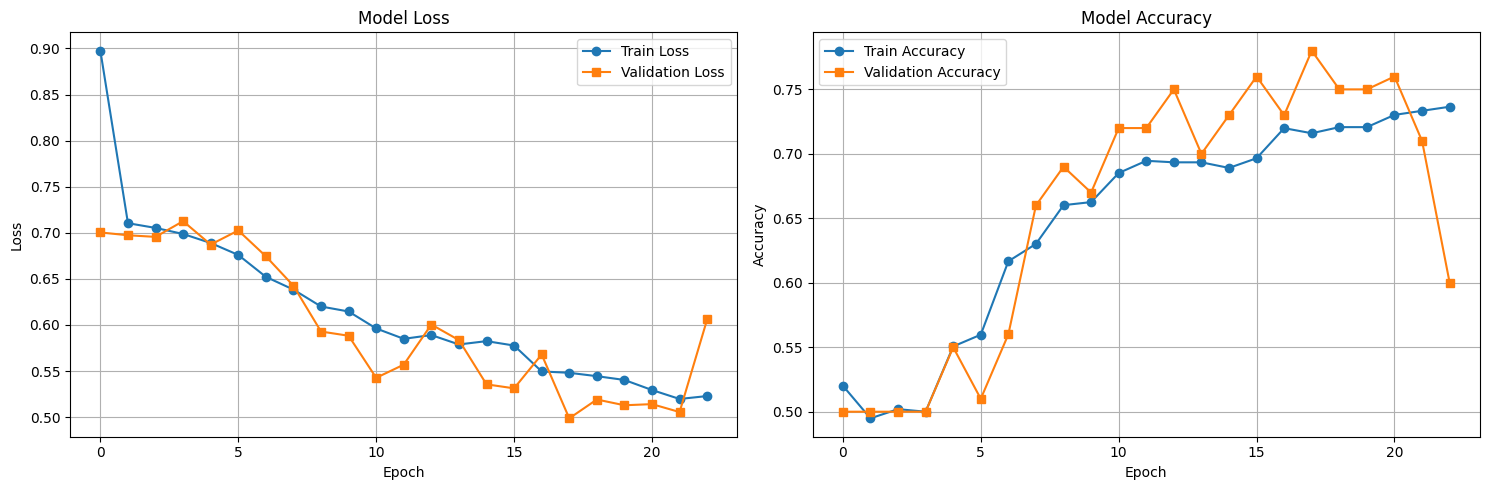

In [22]:
# Create and train ConvNeXt Tiny model
print("Creating ConvNeXt Tiny model...")
convnext_tiny_model = create_convnext_model('convnext_tiny')
convnext_tiny_trainer = ModelTrainer(convnext_tiny_model, train_loader, val_loader, test_loader, device)

print("Training ConvNeXt Tiny model...")
trained_convnext_tiny = convnext_tiny_trainer.train_model(num_epochs=25, model_name="convnext_tiny_autism")

print("Evaluating ConvNeXt Tiny model...")
test_acc_convnext_tiny, preds_convnext_tiny, labels_convnext_tiny = convnext_tiny_trainer.evaluate_model()

print("Plotting ConvNeXt Tiny training history...")
convnext_tiny_trainer.plot_training_history()

### ConvNeXt Small

Creating ConvNeXt Small model...


model.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

Training ConvNeXt Small model...
Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 79/79 [01:26<00:00,  1.09s/it, Loss=0.8474, Acc=0.5051]


Train Loss: 0.8474 Acc: 0.5051


Val : 100%|██████████| 4/4 [00:00<00:00,  4.41it/s, Loss=0.7067, Acc=0.5000]


Val Loss: 0.7067 Acc: 0.5000
✓ New best model saved with validation accuracy: 0.5000

Epoch 2/25
----------


Train : 100%|██████████| 79/79 [01:26<00:00,  1.09s/it, Loss=0.7148, Acc=0.4842]


Train Loss: 0.7148 Acc: 0.4842


Val : 100%|██████████| 4/4 [00:00<00:00,  4.34it/s, Loss=0.6945, Acc=0.5000]


Val Loss: 0.6945 Acc: 0.5000

Epoch 3/25
----------


Train : 100%|██████████| 79/79 [01:25<00:00,  1.09s/it, Loss=0.7011, Acc=0.5036]


Train Loss: 0.7011 Acc: 0.5036


Val : 100%|██████████| 4/4 [00:00<00:00,  4.27it/s, Loss=0.7100, Acc=0.5000]


Val Loss: 0.7100 Acc: 0.5000

Epoch 4/25
----------


Train : 100%|██████████| 79/79 [01:26<00:00,  1.09s/it, Loss=0.7033, Acc=0.5024]


Train Loss: 0.7033 Acc: 0.5024


Val : 100%|██████████| 4/4 [00:00<00:00,  4.46it/s, Loss=0.6975, Acc=0.5000]


Val Loss: 0.6975 Acc: 0.5000

Epoch 5/25
----------


Train : 100%|██████████| 79/79 [01:26<00:00,  1.09s/it, Loss=0.6956, Acc=0.5036]


Train Loss: 0.6956 Acc: 0.5036


Val : 100%|██████████| 4/4 [00:00<00:00,  4.19it/s, Loss=0.6949, Acc=0.5000]


Val Loss: 0.6949 Acc: 0.5000

Epoch 6/25
----------


Train : 100%|██████████| 79/79 [01:25<00:00,  1.09s/it, Loss=0.6947, Acc=0.5032]


Train Loss: 0.6947 Acc: 0.5032


Val : 100%|██████████| 4/4 [00:00<00:00,  4.21it/s, Loss=0.6940, Acc=0.5000]


Val Loss: 0.6940 Acc: 0.5000
Early stopping triggered after 6 epochs
Training complete in 8m 42s
Best validation accuracy: 0.5000
Evaluating ConvNeXt Small model...
Evaluating on test set...


100%|██████████| 10/10 [00:01<00:00,  5.51it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Accuracy: 50.00%
Test Loss: 0.7170

Classification Report:
              precision    recall  f1-score   support

    Autistic       0.50      1.00      0.67       150
Non_Autistic       0.00      0.00      0.00       150

    accuracy                           0.50       300
   macro avg       0.25      0.50      0.33       300
weighted avg       0.25      0.50      0.33       300


Confusion Matrix:
[[150   0]
 [150   0]]
Plotting ConvNeXt Small training history...


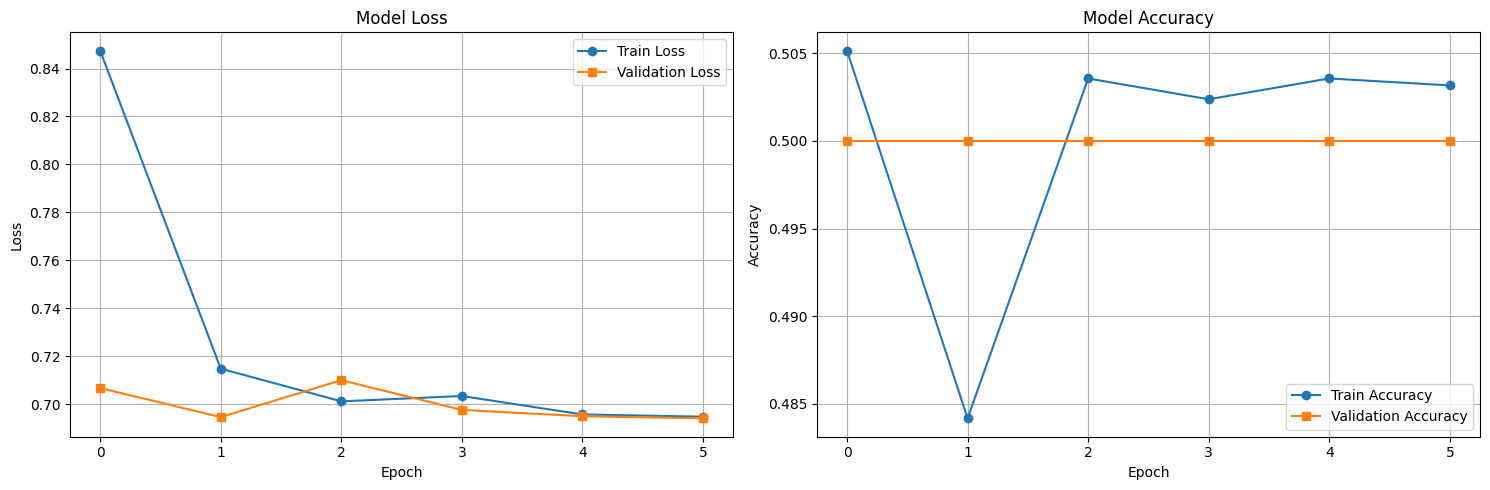

In [23]:
# Create and train ConvNeXt Small model
print("Creating ConvNeXt Small model...")
convnext_small_model = create_convnext_model('convnext_small')
convnext_small_trainer = ModelTrainer(convnext_small_model, train_loader, val_loader, test_loader, device)

print("Training ConvNeXt Small model...")
trained_convnext_small = convnext_small_trainer.train_model(num_epochs=25, model_name="convnext_small_autism")

print("Evaluating ConvNeXt Small model...")
test_acc_convnext_small, preds_convnext_small, labels_convnext_small = convnext_small_trainer.evaluate_model()

print("Plotting ConvNeXt Small training history...")
convnext_small_trainer.plot_training_history()

### ConvNeXt Base

Creating ConvNeXt Base model...


model.safetensors:   0%|          | 0.00/354M [00:00<?, ?B/s]

Training ConvNeXt Base model...
Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 79/79 [01:57<00:00,  1.49s/it, Loss=0.7561, Acc=0.5514]


Train Loss: 0.7561 Acc: 0.5514


Val : 100%|██████████| 4/4 [00:01<00:00,  3.30it/s, Loss=0.6449, Acc=0.6100]


Val Loss: 0.6449 Acc: 0.6100
✓ New best model saved with validation accuracy: 0.6100

Epoch 2/25
----------


Train : 100%|██████████| 79/79 [01:57<00:00,  1.49s/it, Loss=0.5745, Acc=0.6994]


Train Loss: 0.5745 Acc: 0.6994


Val : 100%|██████████| 4/4 [00:01<00:00,  3.27it/s, Loss=0.7417, Acc=0.5500]


Val Loss: 0.7417 Acc: 0.5500

Epoch 3/25
----------


Train : 100%|██████████| 79/79 [01:57<00:00,  1.49s/it, Loss=0.5156, Acc=0.7492]


Train Loss: 0.5156 Acc: 0.7492


Val : 100%|██████████| 4/4 [00:01<00:00,  3.33it/s, Loss=0.6128, Acc=0.6900]


Val Loss: 0.6128 Acc: 0.6900
✓ New best model saved with validation accuracy: 0.6900

Epoch 4/25
----------


Train : 100%|██████████| 79/79 [01:57<00:00,  1.49s/it, Loss=0.4233, Acc=0.8070]


Train Loss: 0.4233 Acc: 0.8070


Val : 100%|██████████| 4/4 [00:01<00:00,  3.25it/s, Loss=0.4999, Acc=0.7500]


Val Loss: 0.4999 Acc: 0.7500
✓ New best model saved with validation accuracy: 0.7500

Epoch 5/25
----------


Train : 100%|██████████| 79/79 [01:57<00:00,  1.49s/it, Loss=0.3984, Acc=0.8192]


Train Loss: 0.3984 Acc: 0.8192


Val : 100%|██████████| 4/4 [00:01<00:00,  3.38it/s, Loss=0.6665, Acc=0.6700]


Val Loss: 0.6665 Acc: 0.6700

Epoch 6/25
----------


Train : 100%|██████████| 79/79 [01:57<00:00,  1.49s/it, Loss=0.3484, Acc=0.8434]


Train Loss: 0.3484 Acc: 0.8434


Val : 100%|██████████| 4/4 [00:01<00:00,  3.38it/s, Loss=0.3944, Acc=0.8000]


Val Loss: 0.3944 Acc: 0.8000
✓ New best model saved with validation accuracy: 0.8000

Epoch 7/25
----------


Train : 100%|██████████| 79/79 [01:57<00:00,  1.49s/it, Loss=0.2959, Acc=0.8790]


Train Loss: 0.2959 Acc: 0.8790


Val : 100%|██████████| 4/4 [00:01<00:00,  3.35it/s, Loss=0.4322, Acc=0.8400]


Val Loss: 0.4322 Acc: 0.8400
✓ New best model saved with validation accuracy: 0.8400

Epoch 8/25
----------


Train : 100%|██████████| 79/79 [01:57<00:00,  1.49s/it, Loss=0.2753, Acc=0.8924]


Train Loss: 0.2753 Acc: 0.8924


Val : 100%|██████████| 4/4 [00:01<00:00,  3.38it/s, Loss=0.7815, Acc=0.7500]


Val Loss: 0.7815 Acc: 0.7500

Epoch 9/25
----------


Train : 100%|██████████| 79/79 [01:57<00:00,  1.49s/it, Loss=0.2462, Acc=0.8924]


Train Loss: 0.2462 Acc: 0.8924


Val : 100%|██████████| 4/4 [00:01<00:00,  3.44it/s, Loss=0.8737, Acc=0.6400]


Val Loss: 0.8737 Acc: 0.6400

Epoch 10/25
----------


Train : 100%|██████████| 79/79 [01:57<00:00,  1.49s/it, Loss=0.1937, Acc=0.9225]


Train Loss: 0.1937 Acc: 0.9225


Val : 100%|██████████| 4/4 [00:01<00:00,  3.44it/s, Loss=0.3960, Acc=0.8600]


Val Loss: 0.3960 Acc: 0.8600
✓ New best model saved with validation accuracy: 0.8600

Epoch 11/25
----------


Train : 100%|██████████| 79/79 [01:57<00:00,  1.49s/it, Loss=0.1470, Acc=0.9391]


Train Loss: 0.1470 Acc: 0.9391


Val : 100%|██████████| 4/4 [00:01<00:00,  3.40it/s, Loss=0.3936, Acc=0.8200]


Val Loss: 0.3936 Acc: 0.8200

Epoch 12/25
----------


Train : 100%|██████████| 79/79 [01:57<00:00,  1.49s/it, Loss=0.1607, Acc=0.9367]


Train Loss: 0.1607 Acc: 0.9367


Val : 100%|██████████| 4/4 [00:01<00:00,  3.37it/s, Loss=0.5017, Acc=0.7800]


Val Loss: 0.5017 Acc: 0.7800

Epoch 13/25
----------


Train : 100%|██████████| 79/79 [01:57<00:00,  1.49s/it, Loss=0.0854, Acc=0.9640]


Train Loss: 0.0854 Acc: 0.9640


Val : 100%|██████████| 4/4 [00:01<00:00,  3.30it/s, Loss=0.6824, Acc=0.8400]


Val Loss: 0.6824 Acc: 0.8400

Epoch 14/25
----------


Train : 100%|██████████| 79/79 [01:57<00:00,  1.49s/it, Loss=0.0976, Acc=0.9640]


Train Loss: 0.0976 Acc: 0.9640


Val : 100%|██████████| 4/4 [00:01<00:00,  3.33it/s, Loss=0.4366, Acc=0.8500]


Val Loss: 0.4366 Acc: 0.8500

Epoch 15/25
----------


Train : 100%|██████████| 79/79 [01:57<00:00,  1.49s/it, Loss=0.0958, Acc=0.9680]


Train Loss: 0.0958 Acc: 0.9680


Val : 100%|██████████| 4/4 [00:01<00:00,  3.46it/s, Loss=0.9419, Acc=0.7300]


Val Loss: 0.9419 Acc: 0.7300
Early stopping triggered after 15 epochs
Training complete in 29m 46s
Best validation accuracy: 0.8600
Evaluating ConvNeXt Base model...
Evaluating on test set...


100%|██████████| 10/10 [00:02<00:00,  3.85it/s]


Test Accuracy: 86.33%
Test Loss: 0.4143

Classification Report:
              precision    recall  f1-score   support

    Autistic       0.83      0.92      0.87       150
Non_Autistic       0.91      0.81      0.86       150

    accuracy                           0.86       300
   macro avg       0.87      0.86      0.86       300
weighted avg       0.87      0.86      0.86       300


Confusion Matrix:
[[138  12]
 [ 29 121]]
Plotting ConvNeXt Base training history...


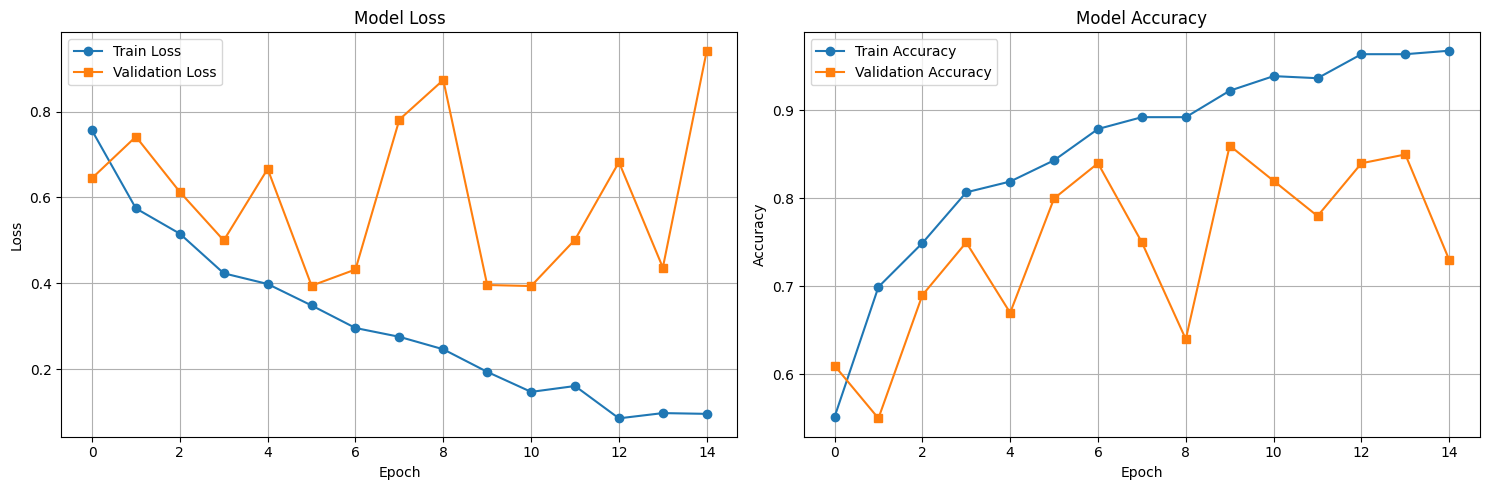

In [24]:
# Create and train ConvNeXt Base model
print("Creating ConvNeXt Base model...")
convnext_base_model = create_convnext_model('convnext_base')
convnext_base_trainer = ModelTrainer(convnext_base_model, train_loader, val_loader, test_loader, device)

print("Training ConvNeXt Base model...")
trained_convnext_base = convnext_base_trainer.train_model(num_epochs=25, model_name="convnext_base_autism")

print("Evaluating ConvNeXt Base model...")
test_acc_convnext_base, preds_convnext_base, labels_convnext_base = convnext_base_trainer.evaluate_model()

print("Plotting ConvNeXt Base training history...")
convnext_base_trainer.plot_training_history()

## 4. MViT v2 (Multiscale Vision Transformer) Training

### MViT v2 Tiny

Creating MViT v2 Tiny model...


model.safetensors:   0%|          | 0.00/96.7M [00:00<?, ?B/s]

Training MViT v2 Tiny model...
Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 79/79 [00:29<00:00,  2.71it/s, Loss=0.7086, Acc=0.5134]


Train Loss: 0.7086 Acc: 0.5134


Val : 100%|██████████| 4/4 [00:00<00:00,  4.83it/s, Loss=0.6978, Acc=0.5000]


Val Loss: 0.6978 Acc: 0.5000
✓ New best model saved with validation accuracy: 0.5000

Epoch 2/25
----------


Train : 100%|██████████| 79/79 [00:29<00:00,  2.72it/s, Loss=0.6864, Acc=0.5720]


Train Loss: 0.6864 Acc: 0.5720


Val : 100%|██████████| 4/4 [00:00<00:00,  4.69it/s, Loss=0.6560, Acc=0.5200]


Val Loss: 0.6560 Acc: 0.5200
✓ New best model saved with validation accuracy: 0.5200

Epoch 3/25
----------


Train : 100%|██████████| 79/79 [00:29<00:00,  2.72it/s, Loss=0.6455, Acc=0.6167]


Train Loss: 0.6455 Acc: 0.6167


Val : 100%|██████████| 4/4 [00:00<00:00,  4.68it/s, Loss=0.6531, Acc=0.6500]


Val Loss: 0.6531 Acc: 0.6500
✓ New best model saved with validation accuracy: 0.6500

Epoch 4/25
----------


Train : 100%|██████████| 79/79 [00:29<00:00,  2.71it/s, Loss=0.6495, Acc=0.6274]


Train Loss: 0.6495 Acc: 0.6274


Val : 100%|██████████| 4/4 [00:00<00:00,  4.51it/s, Loss=0.6280, Acc=0.6700]


Val Loss: 0.6280 Acc: 0.6700
✓ New best model saved with validation accuracy: 0.6700

Epoch 5/25
----------


Train : 100%|██████████| 79/79 [00:29<00:00,  2.71it/s, Loss=0.6281, Acc=0.6566]


Train Loss: 0.6281 Acc: 0.6566


Val : 100%|██████████| 4/4 [00:00<00:00,  4.79it/s, Loss=0.6186, Acc=0.6500]


Val Loss: 0.6186 Acc: 0.6500

Epoch 6/25
----------


Train : 100%|██████████| 79/79 [00:29<00:00,  2.72it/s, Loss=0.6246, Acc=0.6606]


Train Loss: 0.6246 Acc: 0.6606


Val : 100%|██████████| 4/4 [00:00<00:00,  4.59it/s, Loss=0.6368, Acc=0.6400]


Val Loss: 0.6368 Acc: 0.6400

Epoch 7/25
----------


Train : 100%|██████████| 79/79 [00:29<00:00,  2.71it/s, Loss=0.6252, Acc=0.6574]


Train Loss: 0.6252 Acc: 0.6574


Val : 100%|██████████| 4/4 [00:00<00:00,  4.54it/s, Loss=0.5967, Acc=0.7000]


Val Loss: 0.5967 Acc: 0.7000
✓ New best model saved with validation accuracy: 0.7000

Epoch 8/25
----------


Train : 100%|██████████| 79/79 [00:29<00:00,  2.71it/s, Loss=0.6093, Acc=0.6681]


Train Loss: 0.6093 Acc: 0.6681


Val : 100%|██████████| 4/4 [00:00<00:00,  4.47it/s, Loss=0.6067, Acc=0.6600]


Val Loss: 0.6067 Acc: 0.6600

Epoch 9/25
----------


Train : 100%|██████████| 79/79 [00:29<00:00,  2.71it/s, Loss=0.5970, Acc=0.6729]


Train Loss: 0.5970 Acc: 0.6729


Val : 100%|██████████| 4/4 [00:00<00:00,  4.71it/s, Loss=0.6153, Acc=0.6400]


Val Loss: 0.6153 Acc: 0.6400

Epoch 10/25
----------


Train : 100%|██████████| 79/79 [00:29<00:00,  2.71it/s, Loss=0.5930, Acc=0.6760]


Train Loss: 0.5930 Acc: 0.6760


Val : 100%|██████████| 4/4 [00:00<00:00,  4.78it/s, Loss=0.6057, Acc=0.6500]


Val Loss: 0.6057 Acc: 0.6500

Epoch 11/25
----------


Train : 100%|██████████| 79/79 [00:29<00:00,  2.71it/s, Loss=0.5905, Acc=0.6895]


Train Loss: 0.5905 Acc: 0.6895


Val : 100%|██████████| 4/4 [00:00<00:00,  4.58it/s, Loss=0.5960, Acc=0.6400]


Val Loss: 0.5960 Acc: 0.6400

Epoch 12/25
----------


Train : 100%|██████████| 79/79 [00:29<00:00,  2.72it/s, Loss=0.5851, Acc=0.6808]


Train Loss: 0.5851 Acc: 0.6808


Val : 100%|██████████| 4/4 [00:00<00:00,  4.63it/s, Loss=0.6251, Acc=0.6300]


Val Loss: 0.6251 Acc: 0.6300
Early stopping triggered after 12 epochs
Training complete in 6m 1s
Best validation accuracy: 0.7000
Evaluating MViT v2 Tiny model...
Evaluating on test set...


100%|██████████| 10/10 [00:01<00:00,  6.43it/s]


Test Accuracy: 68.67%
Test Loss: 0.5886

Classification Report:
              precision    recall  f1-score   support

    Autistic       0.66      0.75      0.71       150
Non_Autistic       0.72      0.62      0.66       150

    accuracy                           0.69       300
   macro avg       0.69      0.69      0.69       300
weighted avg       0.69      0.69      0.69       300


Confusion Matrix:
[[113  37]
 [ 57  93]]
Plotting MViT v2 Tiny training history...


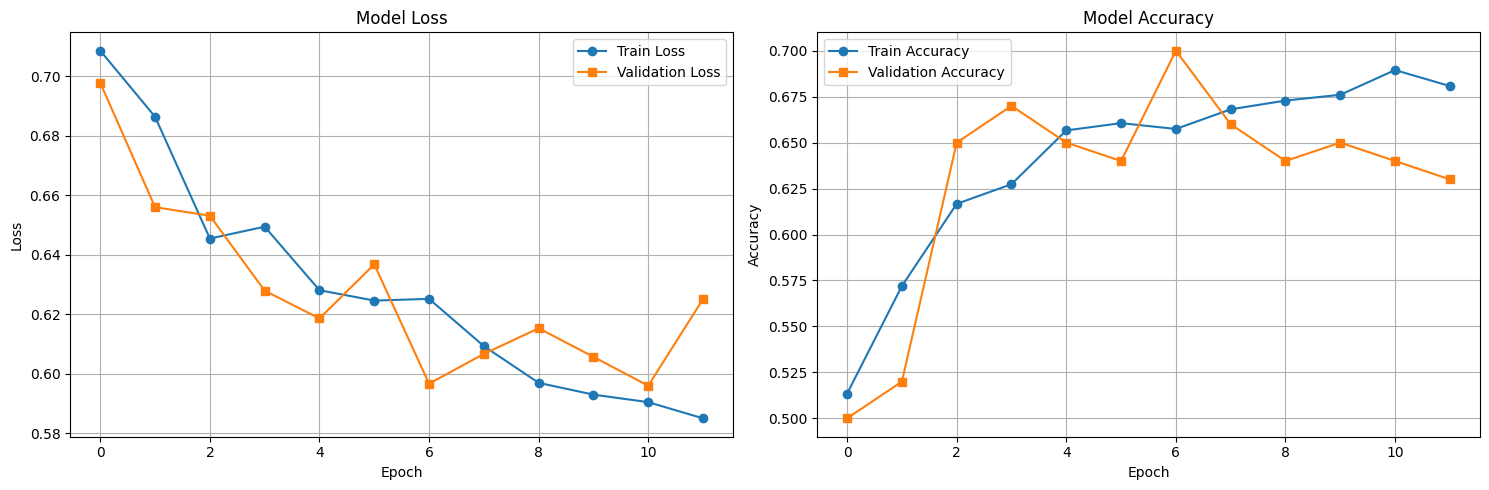

In [25]:
# Create and train MViT v2 Tiny model
print("Creating MViT v2 Tiny model...")
mvit_tiny_model = create_mvit_model('mvitv2_tiny')
mvit_tiny_trainer = ModelTrainer(mvit_tiny_model, train_loader, val_loader, test_loader, device)

print("Training MViT v2 Tiny model...")
trained_mvit_tiny = mvit_tiny_trainer.train_model(num_epochs=25, model_name="mvit_tiny_autism")

print("Evaluating MViT v2 Tiny model...")
test_acc_mvit_tiny, preds_mvit_tiny, labels_mvit_tiny = mvit_tiny_trainer.evaluate_model()

print("Plotting MViT v2 Tiny training history...")
mvit_tiny_trainer.plot_training_history()

### MViT v2 Small

Creating MViT v2 Small model...


model.safetensors:   0%|          | 0.00/140M [00:00<?, ?B/s]

Training MViT v2 Small model...
Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 79/79 [00:39<00:00,  2.00it/s, Loss=0.7024, Acc=0.5115]


Train Loss: 0.7024 Acc: 0.5115


Val : 100%|██████████| 4/4 [00:01<00:00,  3.88it/s, Loss=0.7004, Acc=0.5000]


Val Loss: 0.7004 Acc: 0.5000
✓ New best model saved with validation accuracy: 0.5000

Epoch 2/25
----------


Train : 100%|██████████| 79/79 [00:39<00:00,  1.99it/s, Loss=0.7406, Acc=0.5127]


Train Loss: 0.7406 Acc: 0.5127


Val : 100%|██████████| 4/4 [00:01<00:00,  3.90it/s, Loss=0.6931, Acc=0.5000]


Val Loss: 0.6931 Acc: 0.5000

Epoch 3/25
----------


Train : 100%|██████████| 79/79 [00:39<00:00,  2.00it/s, Loss=0.6971, Acc=0.5016]


Train Loss: 0.6971 Acc: 0.5016


Val : 100%|██████████| 4/4 [00:01<00:00,  3.94it/s, Loss=0.6927, Acc=0.4800]


Val Loss: 0.6927 Acc: 0.4800

Epoch 4/25
----------


Train : 100%|██████████| 79/79 [00:39<00:00,  2.00it/s, Loss=0.6922, Acc=0.5225]


Train Loss: 0.6922 Acc: 0.5225


Val : 100%|██████████| 4/4 [00:01<00:00,  3.81it/s, Loss=0.6865, Acc=0.5500]


Val Loss: 0.6865 Acc: 0.5500
✓ New best model saved with validation accuracy: 0.5500

Epoch 5/25
----------


Train : 100%|██████████| 79/79 [00:39<00:00,  1.99it/s, Loss=0.6798, Acc=0.5597]


Train Loss: 0.6798 Acc: 0.5597


Val : 100%|██████████| 4/4 [00:01<00:00,  3.89it/s, Loss=0.6379, Acc=0.6500]


Val Loss: 0.6379 Acc: 0.6500
✓ New best model saved with validation accuracy: 0.6500

Epoch 6/25
----------


Train : 100%|██████████| 79/79 [00:39<00:00,  1.99it/s, Loss=0.6361, Acc=0.6432]


Train Loss: 0.6361 Acc: 0.6432


Val : 100%|██████████| 4/4 [00:01<00:00,  3.82it/s, Loss=0.6064, Acc=0.6900]


Val Loss: 0.6064 Acc: 0.6900
✓ New best model saved with validation accuracy: 0.6900

Epoch 7/25
----------


Train : 100%|██████████| 79/79 [00:39<00:00,  2.00it/s, Loss=0.6235, Acc=0.6610]


Train Loss: 0.6235 Acc: 0.6610


Val : 100%|██████████| 4/4 [00:00<00:00,  4.08it/s, Loss=0.6263, Acc=0.6900]


Val Loss: 0.6263 Acc: 0.6900

Epoch 8/25
----------


Train : 100%|██████████| 79/79 [00:39<00:00,  1.99it/s, Loss=0.6476, Acc=0.6222]


Train Loss: 0.6476 Acc: 0.6222


Val : 100%|██████████| 4/4 [00:00<00:00,  4.07it/s, Loss=0.6639, Acc=0.6200]


Val Loss: 0.6639 Acc: 0.6200

Epoch 9/25
----------


Train : 100%|██████████| 79/79 [00:39<00:00,  1.99it/s, Loss=0.6402, Acc=0.6353]


Train Loss: 0.6402 Acc: 0.6353


Val : 100%|██████████| 4/4 [00:01<00:00,  3.88it/s, Loss=0.6144, Acc=0.6600]


Val Loss: 0.6144 Acc: 0.6600

Epoch 10/25
----------


Train : 100%|██████████| 79/79 [00:39<00:00,  2.00it/s, Loss=0.6065, Acc=0.6697]


Train Loss: 0.6065 Acc: 0.6697


Val : 100%|██████████| 4/4 [00:00<00:00,  4.05it/s, Loss=0.6480, Acc=0.6300]


Val Loss: 0.6480 Acc: 0.6300

Epoch 11/25
----------


Train : 100%|██████████| 79/79 [00:39<00:00,  2.00it/s, Loss=0.6160, Acc=0.6709]


Train Loss: 0.6160 Acc: 0.6709


Val : 100%|██████████| 4/4 [00:01<00:00,  3.91it/s, Loss=0.6122, Acc=0.6300]


Val Loss: 0.6122 Acc: 0.6300
Early stopping triggered after 11 epochs
Training complete in 7m 28s
Best validation accuracy: 0.6900
Evaluating MViT v2 Small model...
Evaluating on test set...


100%|██████████| 10/10 [00:01<00:00,  5.12it/s]


Test Accuracy: 68.33%
Test Loss: 0.5921

Classification Report:
              precision    recall  f1-score   support

    Autistic       0.67      0.71      0.69       150
Non_Autistic       0.70      0.65      0.67       150

    accuracy                           0.68       300
   macro avg       0.68      0.68      0.68       300
weighted avg       0.68      0.68      0.68       300


Confusion Matrix:
[[107  43]
 [ 52  98]]
Plotting MViT v2 Small training history...


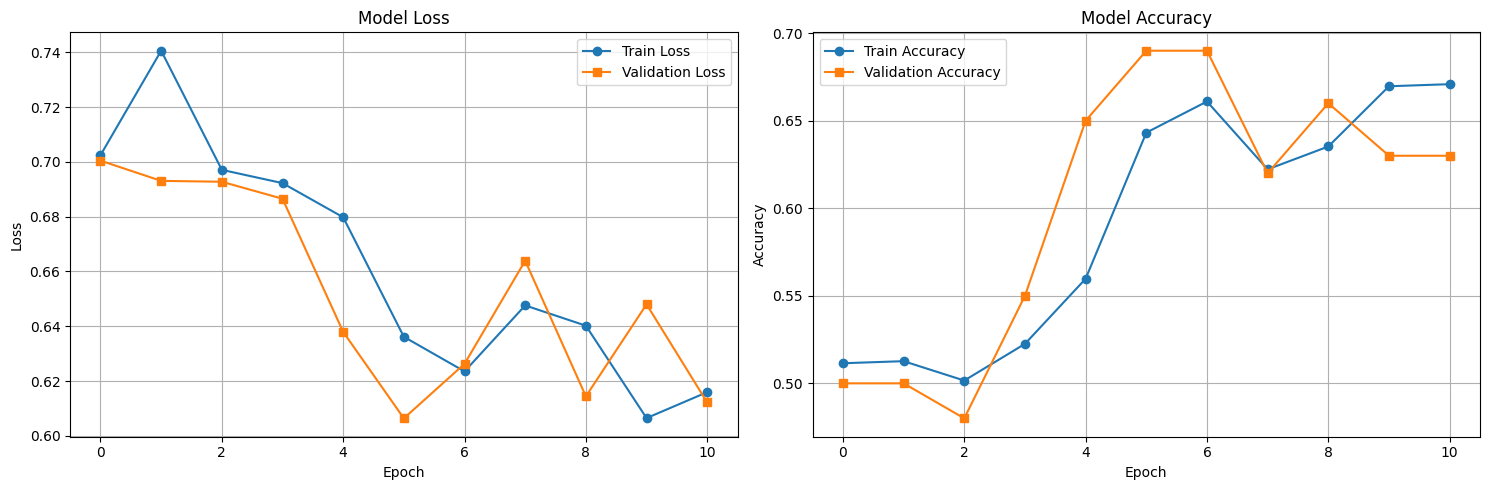

In [26]:
# Create and train MViT v2 Small model
print("Creating MViT v2 Small model...")
mvit_small_model = create_mvit_model('mvitv2_small')
mvit_small_trainer = ModelTrainer(mvit_small_model, train_loader, val_loader, test_loader, device)

print("Training MViT v2 Small model...")
trained_mvit_small = mvit_small_trainer.train_model(num_epochs=25, model_name="mvit_small_autism")

print("Evaluating MViT v2 Small model...")
test_acc_mvit_small, preds_mvit_small, labels_mvit_small = mvit_small_trainer.evaluate_model()

print("Plotting MViT v2 Small training history...")
mvit_small_trainer.plot_training_history()

### MViT v2 Base

Creating MViT v2 Base model...


model.safetensors:   0%|          | 0.00/206M [00:00<?, ?B/s]

Training MViT v2 Base model...
Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 79/79 [00:56<00:00,  1.40it/s, Loss=0.7094, Acc=0.4901]


Train Loss: 0.7094 Acc: 0.4901


Val : 100%|██████████| 4/4 [00:01<00:00,  3.28it/s, Loss=0.7136, Acc=0.5000]


Val Loss: 0.7136 Acc: 0.5000
✓ New best model saved with validation accuracy: 0.5000

Epoch 2/25
----------


Train : 100%|██████████| 79/79 [00:56<00:00,  1.40it/s, Loss=0.6638, Acc=0.5981]


Train Loss: 0.6638 Acc: 0.5981


Val : 100%|██████████| 4/4 [00:01<00:00,  3.14it/s, Loss=0.6737, Acc=0.5900]


Val Loss: 0.6737 Acc: 0.5900
✓ New best model saved with validation accuracy: 0.5900

Epoch 3/25
----------


Train : 100%|██████████| 79/79 [00:56<00:00,  1.40it/s, Loss=0.6644, Acc=0.5934]


Train Loss: 0.6644 Acc: 0.5934


Val : 100%|██████████| 4/4 [00:01<00:00,  3.34it/s, Loss=0.6666, Acc=0.6100]


Val Loss: 0.6666 Acc: 0.6100
✓ New best model saved with validation accuracy: 0.6100

Epoch 4/25
----------


Train : 100%|██████████| 79/79 [00:56<00:00,  1.40it/s, Loss=0.6581, Acc=0.6159]


Train Loss: 0.6581 Acc: 0.6159


Val : 100%|██████████| 4/4 [00:01<00:00,  3.37it/s, Loss=0.6209, Acc=0.6600]


Val Loss: 0.6209 Acc: 0.6600
✓ New best model saved with validation accuracy: 0.6600

Epoch 5/25
----------


Train : 100%|██████████| 79/79 [00:56<00:00,  1.39it/s, Loss=0.6544, Acc=0.6155]


Train Loss: 0.6544 Acc: 0.6155


Val : 100%|██████████| 4/4 [00:01<00:00,  3.19it/s, Loss=0.6432, Acc=0.6200]


Val Loss: 0.6432 Acc: 0.6200

Epoch 6/25
----------


Train : 100%|██████████| 79/79 [00:56<00:00,  1.39it/s, Loss=0.6180, Acc=0.6578]


Train Loss: 0.6180 Acc: 0.6578


Val : 100%|██████████| 4/4 [00:01<00:00,  3.21it/s, Loss=0.6420, Acc=0.6000]


Val Loss: 0.6420 Acc: 0.6000

Epoch 7/25
----------


Train : 100%|██████████| 79/79 [00:56<00:00,  1.40it/s, Loss=0.6206, Acc=0.6574]


Train Loss: 0.6206 Acc: 0.6574


Val : 100%|██████████| 4/4 [00:01<00:00,  3.16it/s, Loss=0.6436, Acc=0.5700]


Val Loss: 0.6436 Acc: 0.5700

Epoch 8/25
----------


Train : 100%|██████████| 79/79 [00:56<00:00,  1.40it/s, Loss=0.6083, Acc=0.6713]


Train Loss: 0.6083 Acc: 0.6713


Val : 100%|██████████| 4/4 [00:01<00:00,  3.24it/s, Loss=0.6227, Acc=0.6300]


Val Loss: 0.6227 Acc: 0.6300

Epoch 9/25
----------


Train : 100%|██████████| 79/79 [00:56<00:00,  1.40it/s, Loss=0.6189, Acc=0.6578]


Train Loss: 0.6189 Acc: 0.6578


Val : 100%|██████████| 4/4 [00:01<00:00,  3.20it/s, Loss=0.6666, Acc=0.5800]


Val Loss: 0.6666 Acc: 0.5800
Early stopping triggered after 9 epochs
Training complete in 8m 42s
Best validation accuracy: 0.6600
Evaluating MViT v2 Base model...
Evaluating on test set...


100%|██████████| 10/10 [00:02<00:00,  3.85it/s]


Test Accuracy: 69.00%
Test Loss: 0.6243

Classification Report:
              precision    recall  f1-score   support

    Autistic       0.71      0.65      0.68       150
Non_Autistic       0.67      0.73      0.70       150

    accuracy                           0.69       300
   macro avg       0.69      0.69      0.69       300
weighted avg       0.69      0.69      0.69       300


Confusion Matrix:
[[ 97  53]
 [ 40 110]]
Plotting MViT v2 Base training history...


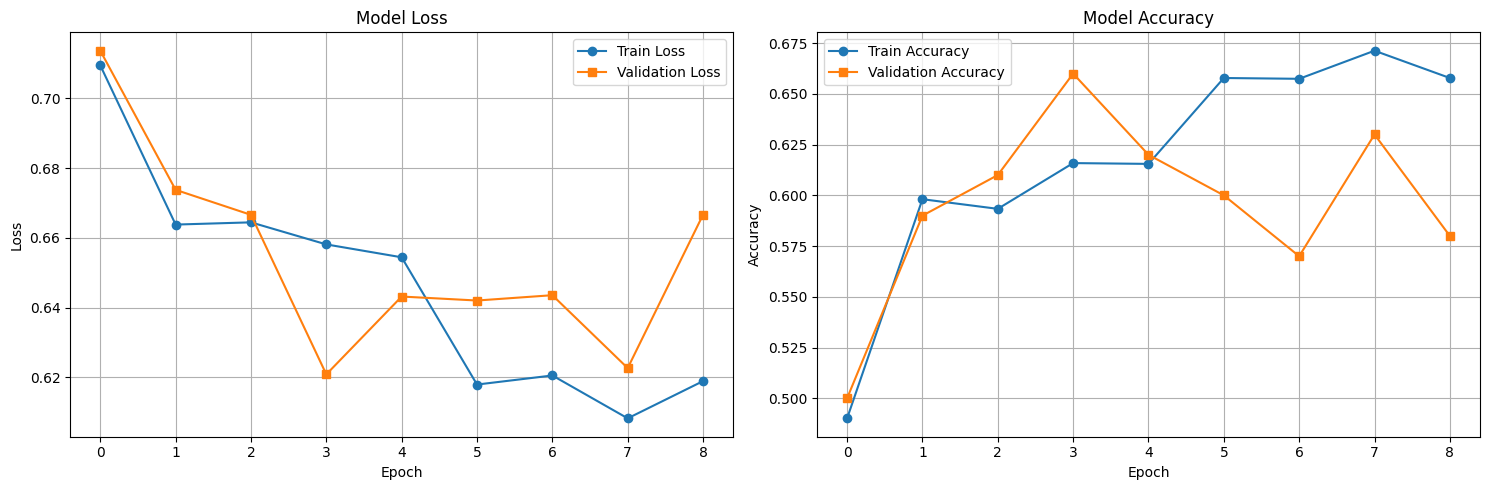

In [27]:
# Create and train MViT v2 Base model
print("Creating MViT v2 Base model...")
mvit_base_model = create_mvit_model('mvitv2_base')
mvit_base_trainer = ModelTrainer(mvit_base_model, train_loader, val_loader, test_loader, device)

print("Training MViT v2 Base model...")
trained_mvit_base = mvit_base_trainer.train_model(num_epochs=25, model_name="mvit_base_autism")

print("Evaluating MViT v2 Base model...")
test_acc_mvit_base, preds_mvit_base, labels_mvit_base = mvit_base_trainer.evaluate_model()

print("Plotting MViT v2 Base training history...")
mvit_base_trainer.plot_training_history()

## 5. CLIP Vision Encoder Training

Creating CLIP Vision Encoder model...


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

Training CLIP Vision Encoder model...
Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 79/79 [00:12<00:00,  6.12it/s, Loss=0.8429, Acc=0.4941]


Train Loss: 0.8429 Acc: 0.4941


Val : 100%|██████████| 4/4 [00:00<00:00,  5.84it/s, Loss=0.6959, Acc=0.5000]


Val Loss: 0.6959 Acc: 0.5000
✓ New best model saved with validation accuracy: 0.5000

Epoch 2/25
----------


Train : 100%|██████████| 79/79 [00:12<00:00,  6.13it/s, Loss=0.6998, Acc=0.5427]


Train Loss: 0.6998 Acc: 0.5427


Val : 100%|██████████| 4/4 [00:00<00:00,  5.73it/s, Loss=0.6457, Acc=0.6100]


Val Loss: 0.6457 Acc: 0.6100
✓ New best model saved with validation accuracy: 0.6100

Epoch 3/25
----------


Train : 100%|██████████| 79/79 [00:12<00:00,  6.15it/s, Loss=0.6817, Acc=0.5669]


Train Loss: 0.6817 Acc: 0.5669


Val : 100%|██████████| 4/4 [00:00<00:00,  5.72it/s, Loss=0.6463, Acc=0.7000]


Val Loss: 0.6463 Acc: 0.7000
✓ New best model saved with validation accuracy: 0.7000

Epoch 4/25
----------


Train : 100%|██████████| 79/79 [00:12<00:00,  6.10it/s, Loss=0.6572, Acc=0.6112]


Train Loss: 0.6572 Acc: 0.6112


Val : 100%|██████████| 4/4 [00:00<00:00,  5.51it/s, Loss=0.6512, Acc=0.6300]


Val Loss: 0.6512 Acc: 0.6300

Epoch 5/25
----------


Train : 100%|██████████| 79/79 [00:13<00:00,  6.07it/s, Loss=0.6530, Acc=0.6214]


Train Loss: 0.6530 Acc: 0.6214


Val : 100%|██████████| 4/4 [00:00<00:00,  5.68it/s, Loss=0.6215, Acc=0.6900]


Val Loss: 0.6215 Acc: 0.6900

Epoch 6/25
----------


Train : 100%|██████████| 79/79 [00:12<00:00,  6.12it/s, Loss=0.6452, Acc=0.6183]


Train Loss: 0.6452 Acc: 0.6183


Val : 100%|██████████| 4/4 [00:00<00:00,  5.72it/s, Loss=0.6284, Acc=0.6800]


Val Loss: 0.6284 Acc: 0.6800

Epoch 7/25
----------


Train : 100%|██████████| 79/79 [00:12<00:00,  6.13it/s, Loss=0.6329, Acc=0.6460]


Train Loss: 0.6329 Acc: 0.6460


Val : 100%|██████████| 4/4 [00:00<00:00,  5.68it/s, Loss=0.6195, Acc=0.6700]


Val Loss: 0.6195 Acc: 0.6700

Epoch 8/25
----------


Train : 100%|██████████| 79/79 [00:12<00:00,  6.13it/s, Loss=0.6317, Acc=0.6428]


Train Loss: 0.6317 Acc: 0.6428


Val : 100%|██████████| 4/4 [00:00<00:00,  5.87it/s, Loss=0.6072, Acc=0.6800]


Val Loss: 0.6072 Acc: 0.6800
Early stopping triggered after 8 epochs
Training complete in 1m 51s
Best validation accuracy: 0.7000
Evaluating CLIP Vision Encoder model...
Evaluating on test set...


100%|██████████| 10/10 [00:01<00:00,  8.58it/s]


Test Accuracy: 65.00%
Test Loss: 0.6423

Classification Report:
              precision    recall  f1-score   support

    Autistic       0.61      0.84      0.71       150
Non_Autistic       0.74      0.46      0.57       150

    accuracy                           0.65       300
   macro avg       0.68      0.65      0.64       300
weighted avg       0.68      0.65      0.64       300


Confusion Matrix:
[[126  24]
 [ 81  69]]
Plotting CLIP Vision Encoder training history...


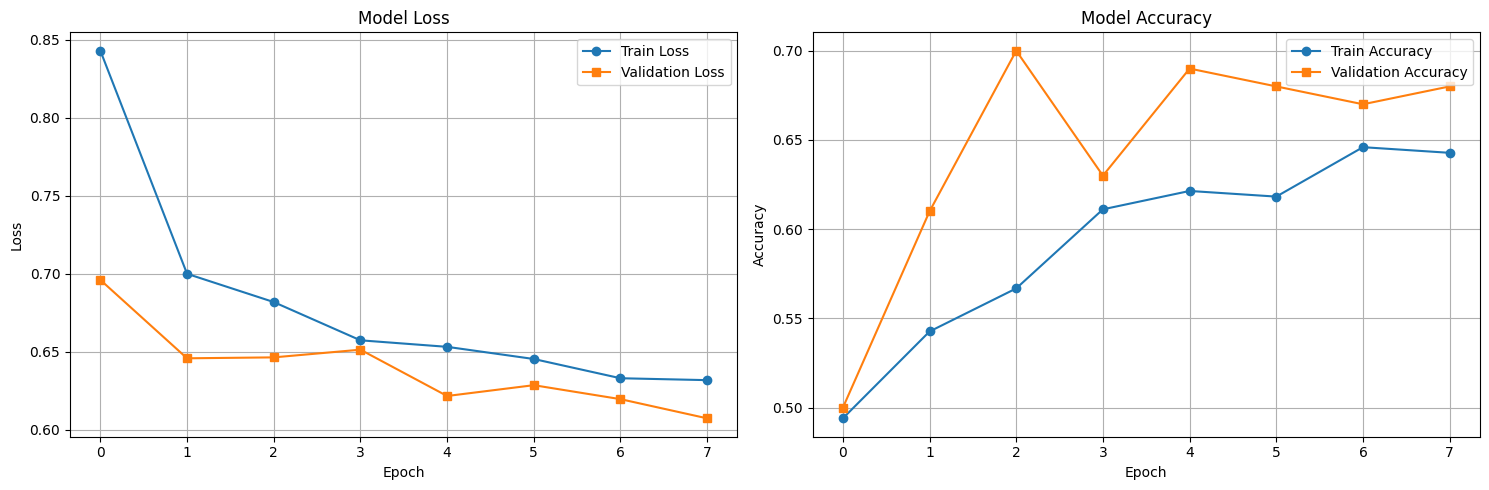

In [28]:
# Create and train CLIP Vision Encoder model
print("Creating CLIP Vision Encoder model...")
clip_model = create_clip_model()
clip_trainer = ModelTrainer(clip_model, train_loader, val_loader, test_loader, device)

print("Training CLIP Vision Encoder model...")
trained_clip = clip_trainer.train_model(num_epochs=25, model_name="clip_vit_b32_autism")

print("Evaluating CLIP Vision Encoder model...")
test_acc_clip, preds_clip, labels_clip = clip_trainer.evaluate_model()

print("Plotting CLIP Vision Encoder training history...")
clip_trainer.plot_training_history()

# Results Summary and Model Comparison

AUTISM DATASET - TRANSFORMER MODELS PERFORMANCE SUMMARY
Model                Test Accuracy (%)
------------------------------------------------------------
DeiT Tiny            72.33          
DeiT Small           72.00          
DeiT Base            73.00          
Swin Tiny            63.00          
Swin Small           63.33          
Swin Base            50.00          
ConvNeXt Tiny        73.33          
ConvNeXt Small       50.00          
ConvNeXt Base        86.33          
MViT v2 Tiny         68.67          
MViT v2 Small        68.33          
MViT v2 Base         69.00          
CLIP ViT-B/32        65.00          

TOP PERFORMING MODELS:
        Model  Test Accuracy
ConvNeXt Base      86.333333
ConvNeXt Tiny      73.333333
    DeiT Base      73.000000
    DeiT Tiny      72.333333
   DeiT Small      72.000000


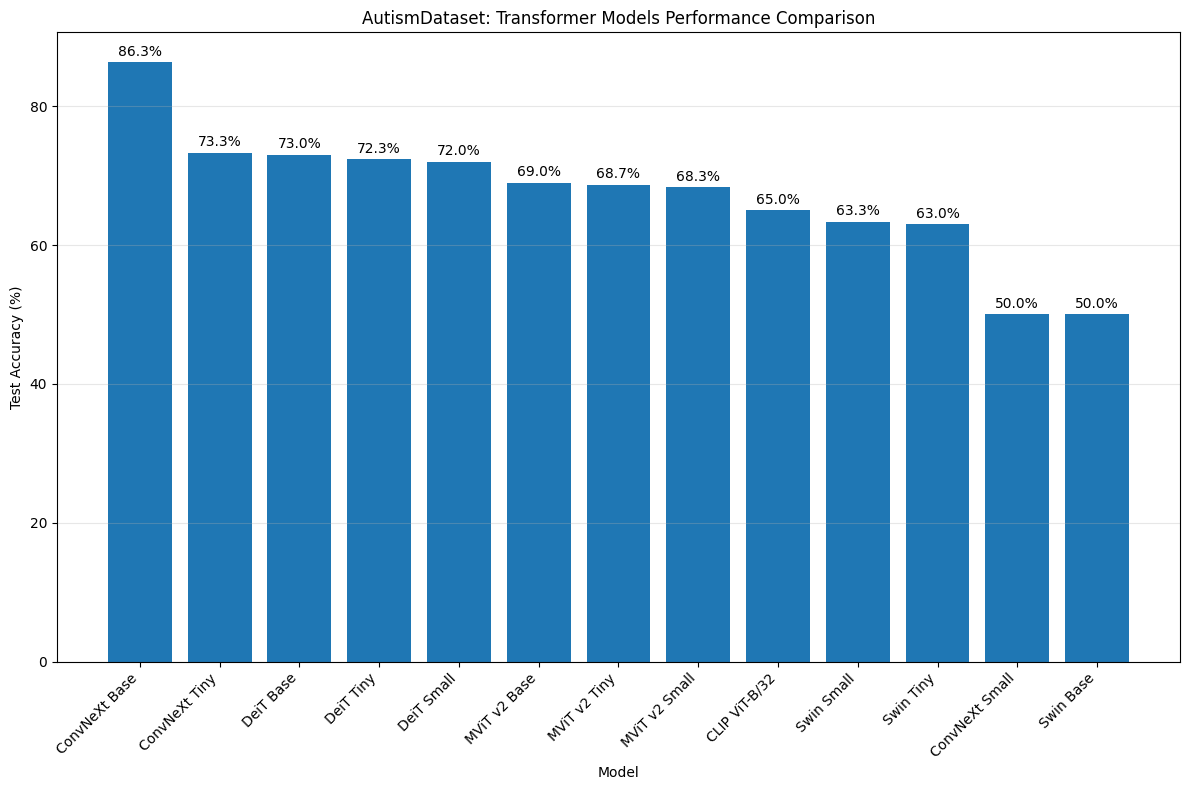


Training completed! Results saved to 'autism_dataset_transformer_results.csv'


In [29]:
# Create a comprehensive results table
results_data = []

# Collect all results
models_results = [
    ("DeiT Tiny", "test_acc_deit_tiny"),
    ("DeiT Small", "test_acc_deit_small"), 
    ("DeiT Base", "test_acc_deit_base"),
    ("Swin Tiny", "test_acc_swin_tiny"),
    ("Swin Small", "test_acc_swin_small"),
    ("Swin Base", "test_acc_swin_base"),
    ("ConvNeXt Tiny", "test_acc_convnext_tiny"),
    ("ConvNeXt Small", "test_acc_convnext_small"),
    ("ConvNeXt Base", "test_acc_convnext_base"),
    ("MViT v2 Tiny", "test_acc_mvit_tiny"),
    ("MViT v2 Small", "test_acc_mvit_small"),
    ("MViT v2 Base", "test_acc_mvit_base"),
    ("CLIP ViT-B/32", "test_acc_clip")
]

print("=" * 60)
print("AUTISM DATASET - TRANSFORMER MODELS PERFORMANCE SUMMARY")
print("=" * 60)
print(f"{'Model':<20} {'Test Accuracy (%)':<15}")
print("-" * 60)

for model_name, acc_var in models_results:
    try:
        accuracy = eval(acc_var)
        print(f"{model_name:<20} {accuracy:<15.2f}")
        results_data.append({"Model": model_name, "Test Accuracy": accuracy})
    except NameError:
        print(f"{model_name:<20} {'Not Available':<15}")

# Create results DataFrame and save
if results_data:
    results_df = pd.DataFrame(results_data)
    results_df = results_df.sort_values('Test Accuracy', ascending=False)
    results_df.to_csv('autism_dataset_transformer_results.csv', index=False)
    
    print("\n" + "=" * 60)
    print("TOP PERFORMING MODELS:")
    print("=" * 60)
    print(results_df.head().to_string(index=False))
    
    # Plot comparison
    plt.figure(figsize=(12, 8))
    bars = plt.bar(results_df['Model'], results_df['Test Accuracy'])
    plt.xlabel('Model')
    plt.ylabel('Test Accuracy (%)')
    plt.title('AutismDataset: Transformer Models Performance Comparison')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.1f}%', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig('autism_dataset_transformer_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

print("\nTraining completed! Results saved to 'autism_dataset_transformer_results.csv'")